# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (uti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_uti_admitted', 'duration_uti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [85]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]
    print(sum_betas_hazard[30].quantile(0.50))  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_uti/data_uti_record_cph_uti.txt", "w")
a.write("")
a.writelines(['data_uti_1 #with a record, #with no record: %.0f' % (data['uti_date_1'].notna().sum()), ', %.0f' % (data['uti_date_1'].isna().sum()),
              '\ndata_uti_2 #with a record, #with no record: %.0f' % (data['uti_date_2'].notna().sum()), ', %.0f' % (data['uti_date_2'].isna().sum()),
              '\ndata_uti_3 #with a record, #with no record: %.0f' % (data['uti_date_3'].notna().sum()), ', %.0f' % (data['uti_date_3'].isna().sum()),
              '\ndata_uti_4 #with a record, #with no record: %.0f' % (data['uti_date_4'].notna().sum()), ', %.0f' % (data['uti_date_4'].isna().sum()),
              '\ndata_uti_5 #with a record, #with no record: %.0f' % (data['uti_date_5'].notna().sum()), ', %.0f' % (data['uti_date_5'].isna().sum()),
              '\ndata_uti_6 #with a record, #with no record: %.0f' % (data['uti_date_6'].notna().sum()), ', %.0f' % (data['uti_date_6'].isna().sum()),
              '\ndata_uti_7 #with a record, #with no record: %.0f' % (data['uti_date_7'].notna().sum()), ', %.0f' % (data['uti_date_7'].isna().sum()),
              '\ndata_uti_8 #with a record, #with no record: %.0f' % (data['uti_date_8'].notna().sum()), ', %.0f' % (data['uti_date_8'].isna().sum()),
              '\ndata_uti_9 #with a record, #with no record: %.0f' % (data['uti_date_9'].notna().sum()), ', %.0f' % (data['uti_date_9'].isna().sum()),
              '\ndata_uti_10 #with a record, #with no record: %.0f' % (data['uti_date_10'].notna().sum()), ', %.0f' % (data['uti_date_10'].isna().sum()),
              '\ndata_uti_11 #with a record, #with no record: %.0f' % (data['uti_date_11'].notna().sum()), ', %.0f' % (data['uti_date_11'].isna().sum()),
              '\ndata_uti_12 #with a record, #with no record: %.0f' % (data['uti_date_12'].notna().sum()), ', %.0f' % (data['uti_date_12'].isna().sum()),
              '\ndata_uti_13 #with a record, #with no record: %.0f' % (data['uti_date_13'].notna().sum()), ', %.0f' % (data['uti_date_13'].isna().sum()),
              '\ndata_uti_14 #with a record, #with no record: %.0f' % (data['uti_date_14'].notna().sum()), ', %.0f' % (data['uti_date_14'].isna().sum()),
              '\ndata_uti_15 #with a record, #with no record: %.0f' % (data['uti_date_15'].notna().sum()), ', %.0f' % (data['uti_date_15'].isna().sum()),
              '\ndata_uti_16 #with a record, #with no record: %.0f' % (data['uti_date_16'].notna().sum()), ', %.0f' % (data['uti_date_16'].isna().sum()),
              '\ndata_uti_17 #with a record, #with no record: %.0f' % (data['uti_date_17'].notna().sum()), ', %.0f' % (data['uti_date_17'].isna().sum()),
              '\ndata_uti_18 #with a record, #with no record: %.0f' % (data['uti_date_18'].notna().sum()), ', %.0f' % (data['uti_date_18'].isna().sum()),
              '\ndata_uti_19 #with a record, #with no record: %.0f' % (data['uti_date_19'].notna().sum()), ', %.0f' % (data['uti_date_19'].isna().sum()),
              '\ndata_uti_20 #with a record, #with no record: %.0f' % (data['uti_date_20'].notna().sum()), ', %.0f' % (data['uti_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37265
1.0     36981
2.0     32875
3.0     24729
4.0     15050
6.0     12230
7.0     10015
5.0      8404
8.0      7831
9.0      5714
10.0     3394
11.0     1919
12.0     1391
13.0      824
14.0      572
15.0      377
16.0      235
17.0      113
18.0       50
19.0       20
20.0        7
21.0        3
23.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(359967, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] #gp_cons_uti
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_uti.date.min()}')
print(f'max date: {data_uti.date.max()}')
print(f'length of data_uti: {len(data_uti)}')

min date: 2019-01
max date: 2022-11
length of data_uti: 359967


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

print(data_uti['season'].value_counts())
print(f'\nmin date: {data_uti.date.min()}')
print(f'max date: {data_uti.date.max()}')
print(f'length: {len(data_uti)}')

summer    93808
spring    92966
winter    82696
autumn    69240
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 338710


In [24]:
data_uti = data_uti[data_uti['date'] <= '2019-12']
# data_uti = data_uti[(data_uti['date'] >= '2020-03') & (data_uti['date']<= '2021-03')]
# data_uti = data_uti[data_uti['date'] >= '2021-04']
# print(f'min date: {data_uti.date.min()}')
# print(f'max date: {data_uti.date.max()}')

In [25]:
#add period variable
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [26]:
#scenario 1
#not hosped (nothing happened)
#data_uti = data_uti[data_uti['admitted_uti_date'].notnull()]
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    64519
Name: event_uti_admitted, dtype: int64

In [27]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days #gp_cons_uti
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1
# data_uti['event_uti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]
data_uti['delta_uti_admitted'].value_counts()

779.0     38
633.0     32
585.0     32
727.0     31
758.0     31
          ..
1384.0     1
1415.0     1
1382.0     1
1383.0     1
1395.0     1
Name: delta_uti_admitted, Length: 1403, dtype: int64

In [28]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_uti.loc[data_uti['delta_admitted_died'] >= 0, 'event_uti_admitted'] = 0
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0
# data_uti['event_uti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_uti.loc[data_uti['delta_admitted_deregistered'] >= 0, 'event_uti_admitted'] = 0
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0
# data_uti['event_uti_admitted'].value_counts()

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_uti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

85998

In [29]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)
data_uti['event_uti_admitted'].value_counts()

0.0    88039
1.0      642
Name: event_uti_admitted, dtype: int64

In [30]:
#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30
data_uti['duration_uti_admitted'].value_counts()

30.0    88056
4.0        28
26.0       28
19.0       28
13.0       27
27.0       26
29.0       25
25.0       23
14.0       23
2.0        23
23.0       22
20.0       21
16.0       21
21.0       21
3.0        21
28.0       21
1.0        21
15.0       20
24.0       20
11.0       19
9.0        19
7.0        19
10.0       19
8.0        18
12.0       17
18.0       17
17.0       16
6.0        16
22.0       16
0.0        15
5.0        15
Name: duration_uti_admitted, dtype: int64

In [31]:
# give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1
data_uti['event_uti_admitted'].value_counts()

0.0    88039
1.0      642
Name: event_uti_admitted, dtype: int64

In [32]:
#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

In [33]:
# data_uti[data_uti['duration_uti_admitted']==0][['delta_uti_admitted', 'uti_date', 'gp_cons_uti', 'admitted_uti_date', 'delta_uti_admitted', 'delta_admitted_died_deregistered', 'event_uti_admitted', 'duration_uti_admitted']]
# data_uti.loc[151:200, ['event_uti_admitted', 'duration_uti_admitted']]
# data_uti.loc[201:250, ['event_uti_admitted', 'duration_uti_admitted']].sort_values(by=['duration_uti_admitted'])
data_uti[['event_uti_admitted', 'duration_uti_admitted']].sort_values(by=['duration_uti_admitted'])

,event_uti_admitted,duration_uti_admitted
119933,1.0,1.0
302091,1.0,1.0
262983,1.0,1.0
108006,1.0,1.0
103549,1.0,1.0
...,...,...
119617,0.0,30.0
119615,0.0,30.0
119614,0.0,30.0
119636,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [34]:
# prep before plot
data_uti['age'][data_uti['age'] < 0] = np.nan
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_uti = data_uti[~(data_uti['age'] < 18)]  
print(f'Min age: {data_uti.age.min()}')

## remove died cases
#data_uti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
# replace 0s with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [35]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking})

In [36]:
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_uti['region_imp'] = data_uti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_uti.region.isnull().sum()}')
    data_uti = data_uti[data_uti['region'].notna()]

print(f'Cound of missing values in variable region: {data_uti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_uti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      10579
East                         5460
East Midlands                5433
North West                   5376
South West                   5374
West Midlands                5368
Yorkshire and The Humber     5331
North East                   5268
South East                   5253
Name: region, dtype: int64


In [37]:
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_uti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_uti.antibacterial_brit.mean():.3f}')
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)
    # data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_uti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_uti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.256

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.256


In [38]:
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_uti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_uti.ethnicity.value_counts()}')
    # data_uti['ethnicity'] = data_uti['ethnicity'].astype(str)
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_uti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_uti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 13402
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    31938
3.0     4071
5.0     4031
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    31938
0.0    13402
3.0     4071
5.0     4031
Name: ethnicity, dtype: int64


In [39]:
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_uti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_uti.smoking_status.value_counts()}')
    # data_uti['smoking_status'] = data_uti['smoking_status'].astype(str)
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_uti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_uti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 22105
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    20966
3.0     6976
2.0     3395
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    22105
1.0    20966
3.0     6976
2.0     3395
Name: smoking_status, dtype: int64


In [40]:
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_uti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_uti.imd.value_counts()}')
    # data_uti['imd'] = data_uti['imd'].astype(str)
    data_uti['imd'] = data_uti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_uti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_uti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    10261
2    10237
5    10171
4    10051
1     9976
0     2746
Name: imd, dtype: int64


In [41]:
data_uti['bmi_cat'] = 5
col_bmi_cat = data_uti.columns.get_loc('bmi_cat')

col_sex = data_uti.columns.get_loc('sex')
col_age = data_uti.columns.get_loc('age')
col_bmi = data_uti.columns.get_loc('bmi')

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, col_bmi] >= 30:
        data_uti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_uti.iat[idx, col_bmi] >= 25) and (data_uti.iat[idx, col_bmi] < 30):
        data_uti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_uti.iat[idx, col_bmi] >= 18.5) and (data_uti.iat[idx, col_bmi] < 25):
        data_uti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_uti.iat[idx, col_bmi] < 18.5:
        data_uti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_uti['bmi_cat'].value_counts()

1    27895
5    13530
2     5877
3     4401
4     1739
Name: bmi_cat, dtype: int64

In [42]:
if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_uti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_uti.bmi_cat.value_counts()}')
    # data_uti['bmi_cat'] = data_uti['bmi_cat'].astype(str)
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_uti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_uti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    27895
5    13530
2     5877
3     4401
4     1739
Name: bmi_cat, dtype: int64


In [43]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])

#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)
data_uti['ab_type_cat'].value_counts()

no             48134
0               4264
other            615
Amoxicillin      307
Doxycycline      122
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [44]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [45]:
# reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})
data_uti['ab_type_cat'].value_counts()

no             48134
other           4879
Amoxicillin      307
Doxycycline      122
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [46]:
# categorising
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_uti['CCI_cat'].value_counts()

low          18678
medium       10746
very_low      9702
very_high     8793
high          5523
Name: CCI_cat, dtype: int64

In [47]:
# assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)
data_uti['antibacterial_brit'].max()

data_uti['antibacterial_brit_cat'] = pd.cut(data_uti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_uti['antibacterial_brit_cat'].value_counts()

low       30810
high      13321
medium     9311
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

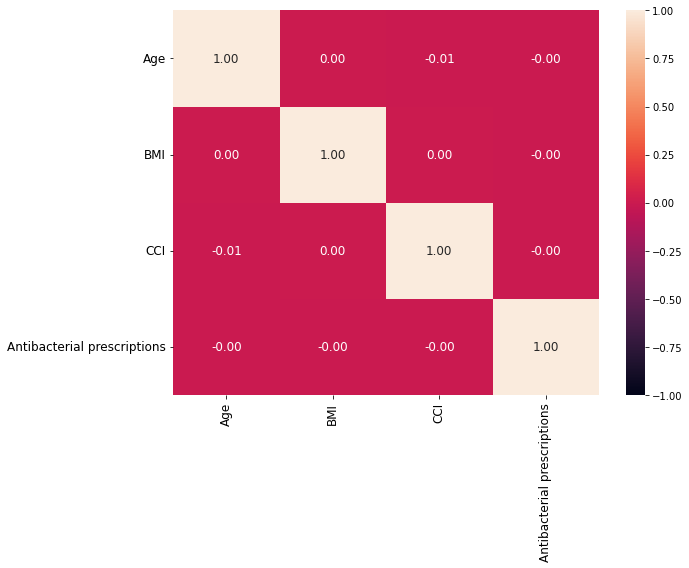

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

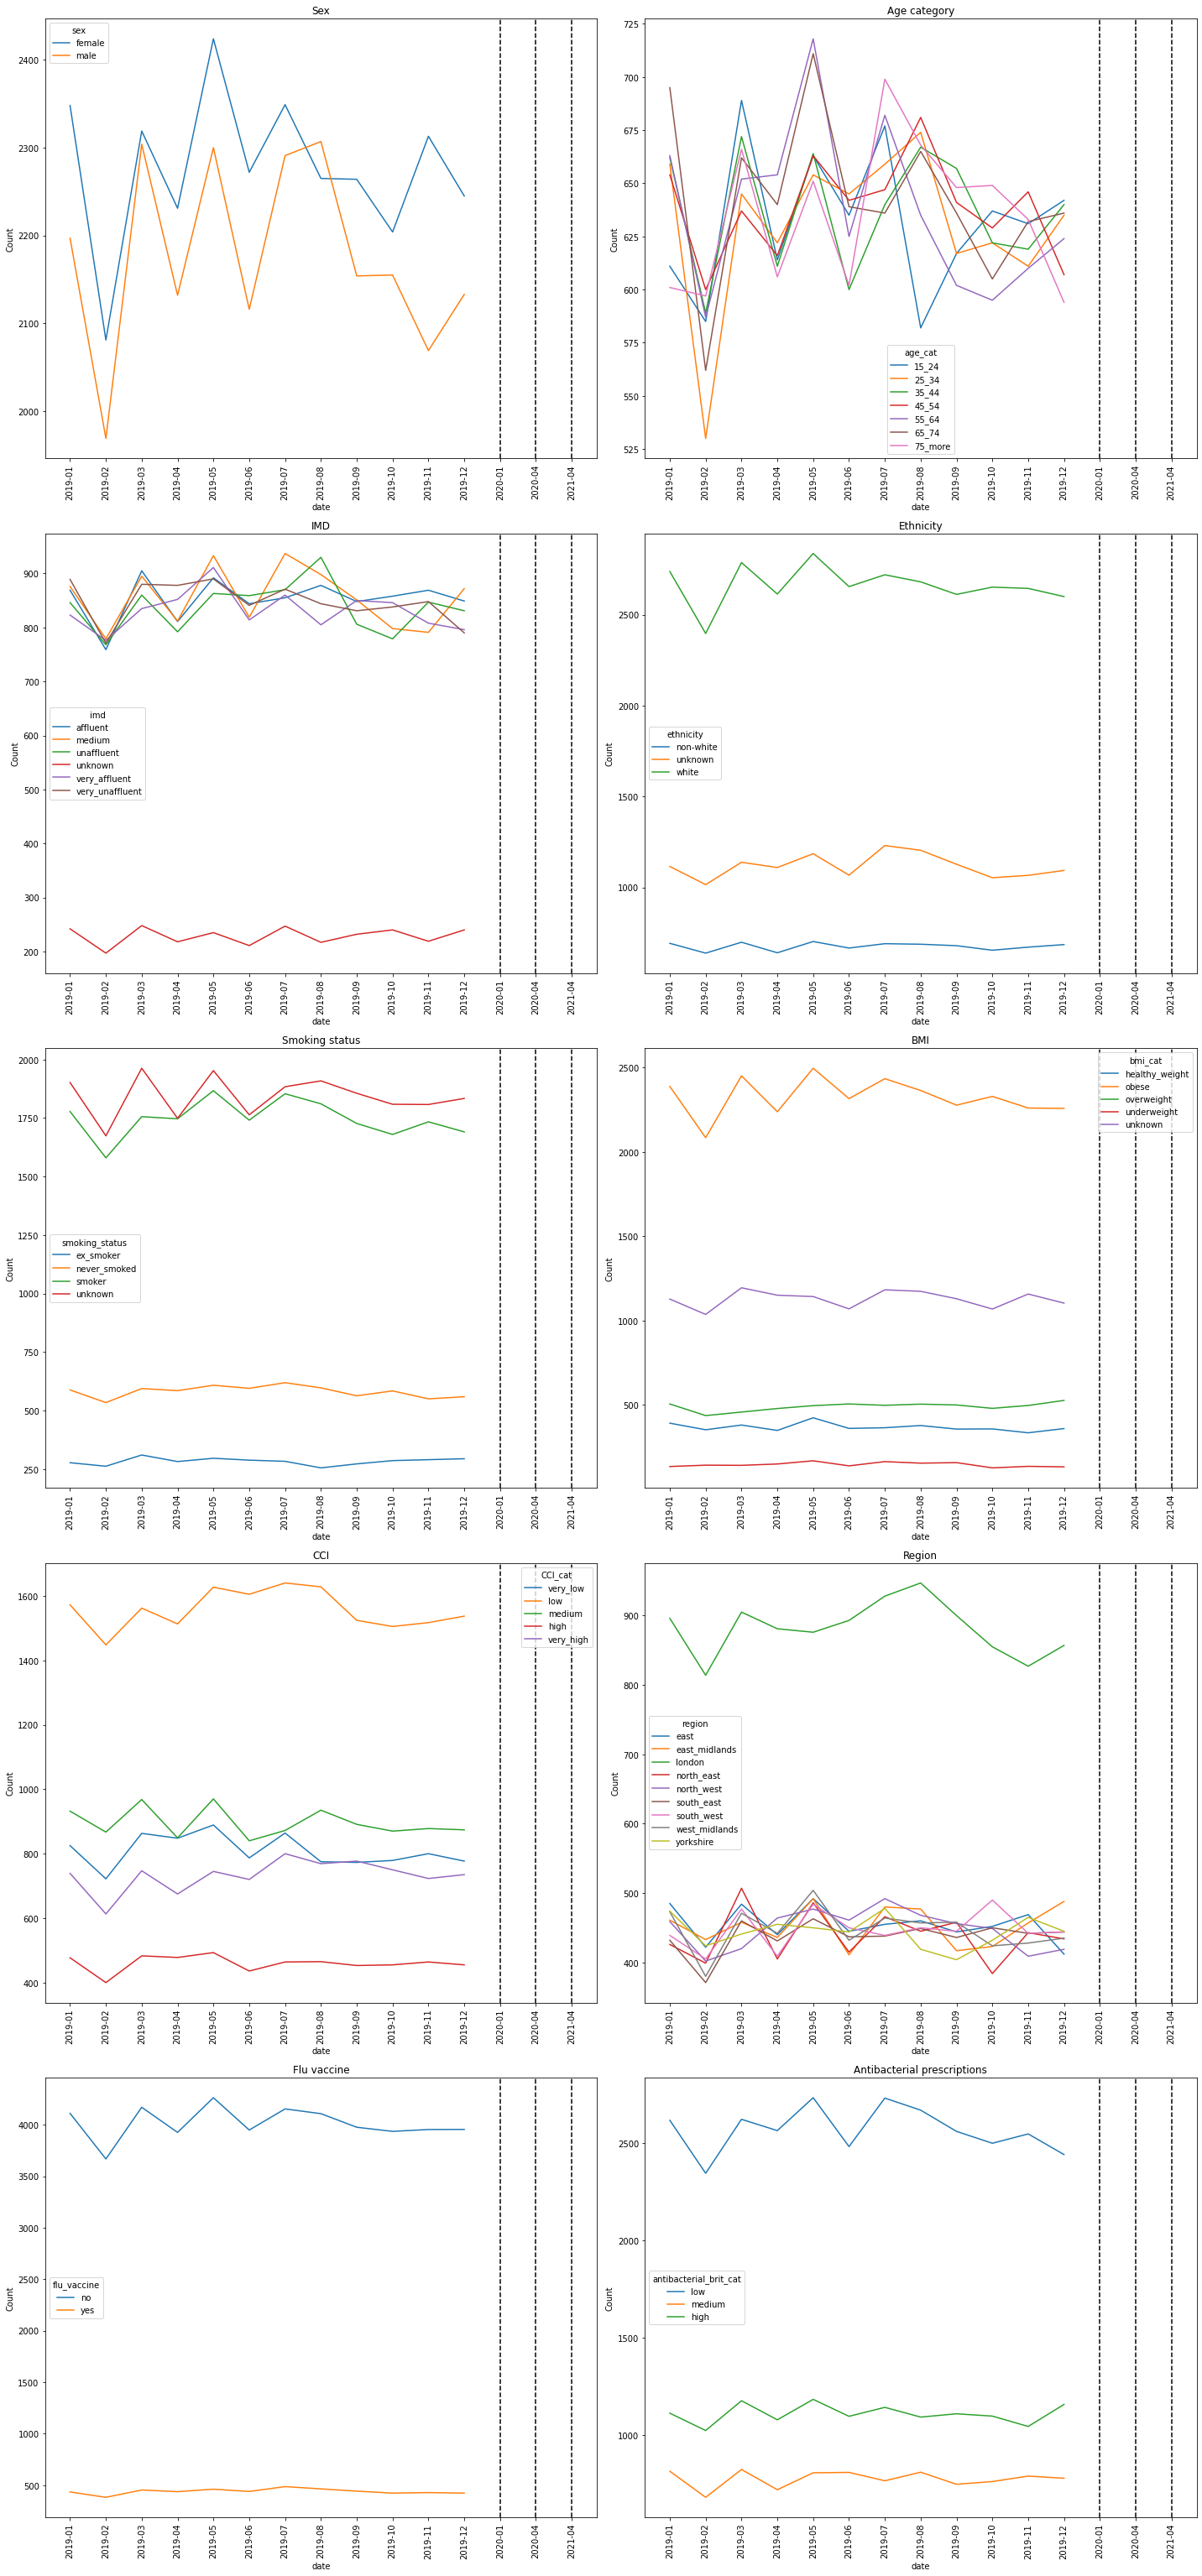

In [49]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_uti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_uti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_uti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_uti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_uti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_uti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_uti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_uti, 'region', 'Region', axes[3,1])
create_lineplot(data_uti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_uti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of uti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/risk_factors_cat_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of uti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [50]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                       'event_uti_admitted', 'duration_uti_admitted'
                        ]]

data_uti.shape

(53442, 18)

In [51]:
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]
#switch variable uti_ab_date into a binary variable
data_uti_incdt[['uti_ab_date']] = data_uti_incdt[['uti_ab_date']].where(data_uti_incdt[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_uti_prevl[['uti_ab_date']] = data_uti_prevl[['uti_ab_date']].where(data_uti_prevl[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_uti_incdt_males = data_uti_incdt[data_uti_incdt['sex'] == 'male']
data_uti_incdt_females = data_uti_incdt[data_uti_incdt['sex'] == 'female']
data_uti_prevl_males = data_uti_prevl[data_uti_prevl['sex'] == 'male']
data_uti_prevl_females = data_uti_prevl[data_uti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_uti_incdt_15_24 = data_uti_incdt[data_uti_incdt['age_cat'] == '15_24']
data_uti_incdt_25_34 = data_uti_incdt[data_uti_incdt['age_cat'] == '25_34']
data_uti_incdt_35_44 = data_uti_incdt[data_uti_incdt['age_cat'] == '35_44']
data_uti_incdt_45_54 = data_uti_incdt[data_uti_incdt['age_cat'] == '45_54']
data_uti_incdt_55_64 = data_uti_incdt[data_uti_incdt['age_cat'] == '55_64']
data_uti_incdt_65_74 = data_uti_incdt[data_uti_incdt['age_cat'] == '65_74']
data_uti_incdt_75_more = data_uti_incdt[data_uti_incdt['age_cat'] == '75_more']
data_uti_prevl_15_24 = data_uti_prevl[data_uti_prevl['age_cat'] == '15_24']
data_uti_prevl_25_34 = data_uti_prevl[data_uti_prevl['age_cat'] == '25_34']
data_uti_prevl_35_44 = data_uti_prevl[data_uti_prevl['age_cat'] == '35_44']
data_uti_prevl_45_54 = data_uti_prevl[data_uti_prevl['age_cat'] == '45_54']
data_uti_prevl_55_64 = data_uti_prevl[data_uti_prevl['age_cat'] == '55_64']
data_uti_prevl_65_74 = data_uti_prevl[data_uti_prevl['age_cat'] == '65_74']
data_uti_prevl_75_more = data_uti_prevl[data_uti_prevl['age_cat'] == '75_more']

data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['date'] <= '2019-12']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['date'] >= '2020-03') & (data_uti_incdt['date']<= '2021-03')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['date'] <= '2021-04']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['date'] <= '2019-12']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['date'] >= '2020-03') & (data_uti_prevl['date']<= '2021-03')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_uti_incdt_abtype_0 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[0]]
# data_uti_incdt_abtype_1 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[1]]
# data_uti_incdt_abtype_2 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[2]]
# data_uti_incdt_abtype_3 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[3]]
# data_uti_prevl_abtype_0 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[0]]
# data_uti_prevl_abtype_1 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[1]]
# data_uti_prevl_abtype_2 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[2]]
# data_uti_prevl_abtype_3 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_uti_incdt_abs = data_uti_incdt[data_uti_incdt['uti_ab_date'] == 1]
# data_uti_prevl_abs = data_uti_prevl[data_uti_prevl['uti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['uti_ab_date'].isnull()] #gp_cons_uti_ab
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

print(f'shape of data_uti_incdt: {data_uti_incdt.shape}')
print(f'shape of data_uti_prevl: {data_uti_prevl.shape}')
print(f'shape of data_uti_no_abs_incdt: {data_uti_no_abs_incdt.shape}')
print(f'shape of data_uti_abs_incdt: {data_uti_abs_incdt.shape}')
print(f'shape of data_uti_no_abs_prevl: {data_uti_no_abs_prevl.shape}')
print(f'shape of data_uti_abs_prevl: {data_uti_abs_prevl.shape}')
print(f'\nvalue counts of data_uti_no_abs_incdt: \n{data_uti_no_abs_incdt.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_abs_incdt: \n{data_uti_abs_incdt.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_no_abs_prevl: \n{data_uti_no_abs_prevl.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_abs_prevl: \n{data_uti_abs_prevl.event_uti_admitted.value_counts()}')

shape of data_uti_incdt: (48048, 18)
shape of data_uti_prevl: (5394, 18)
shape of data_uti_no_abs_incdt: (43286, 18)
shape of data_uti_abs_incdt: (4762, 18)
shape of data_uti_no_abs_prevl: (4848, 18)
shape of data_uti_abs_prevl: (546, 18)

value counts of data_uti_no_abs_incdt: 
0.0    42990
1.0      296
Name: event_uti_admitted, dtype: int64
value counts of data_uti_abs_incdt: 
0.0    4730
1.0      32
Name: event_uti_admitted, dtype: int64
value counts of data_uti_no_abs_prevl: 
0.0    4816
1.0      32
Name: event_uti_admitted, dtype: int64
value counts of data_uti_abs_prevl: 
0.0    542
1.0      4
Name: event_uti_admitted, dtype: int64


In [52]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 32464 total observations, 32253 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 32464
number of events observed = 211
   partial log-likelihood = -2171.38
         time fit was run = 2022-11-29 13:11:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.21            -0.30             0.51                 0.74                 1.66
CCI_cat[T.medium]                0.23       1.26       0.22            -0.21             0.67                 0.81                 1.95
CCI_cat[T.high]                  0.04       1.04       0.28            -0.51             0.59                 0.60                 1.80
CCI_cat[T.very_high]             0.17       1.18       0.24            -0.30             0.63                 0.74                 1.88
age_cat[T.25_34]                -0.19       0.83       0.26            -0.70             0.32                 0.50                 1.38
age_cat[T.35_44]                -0.12       0.88       0.25            -0.62             0.37                 0.54                 1.45
age_cat[T.45_54]                -0.12       0.89       0.25            -0.61             0.38                 0.54                 1.46
age_cat[T.55_64]                 0.03       1.03       0.24            -0.44             0.51                 0.64                 1.67
age_cat[T.65_74]                -0.13       0.88       0.25            -0.63             0.36                 0.53                 1.44
age_cat[T.75_more]              -0.22       0.81       0.26            -0.73             0.29                 0.48                 1.34
antibacterial_brit              -0.05       0.95       0.05            -0.15             0.05                 0.86                 1.05
bmi_cat[T.obese]                 0.19       1.21       0.28            -0.35             0.73                 0.71                 2.07
bmi_cat[T.overweight]            0.23       1.25       0.33            -0.41             0.87                 0.66                 2.38
bmi_cat[T.underweight]           0.40       1.50       0.42            -0.42             1.23                 0.65                 3.42
bmi_cat[T.unknown]               0.08       1.08       0.29            -0.50             0.65                 0.61                 1.92
ethnicity[T.unknown]            -0.15       0.86       0.22            -0.58             0.28                 0.56                 1.32
ethnicity[T.white]              -0.11       0.89       0.19            -0.48             0.26                 0.62                 1.29
flu_vaccine[T.yes]              -0.16       0.85       0.25            -0.64             0.32                 0.53                 1.38
imd[T.medium]                    0.41       1.51       0.22            -0.02             0.84                 0.98                 2.32
imd[T.unaffluent]                0.20       1.23       0.23            -0.25             0.65                 0.78                 1.92
imd[T.unknown]                  -0.13       0.87       0.39            -0.90             0.63                 0.41                 1.89
imd[T.very_affluent]             0.11       1.12       0.23            -0.35             0.57                 0.71                 1.77
imd[T.very_unaffluent]           0.04       1.04       0.24            -0.42             0.51                 0.65                 1.66
region[T.east_midlands]         -0.77       0.46       0.32            -1.41            -0.14                 0.24                 0.87
region[T.london]                -0.09       0.91       0.23           

12775


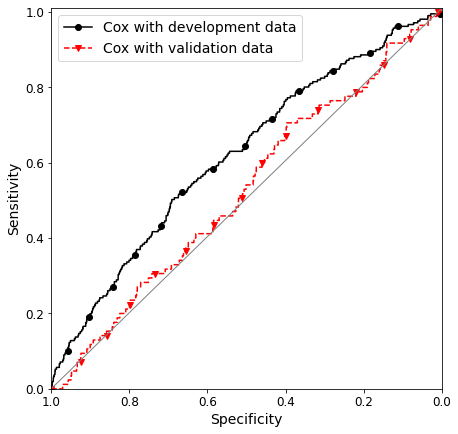

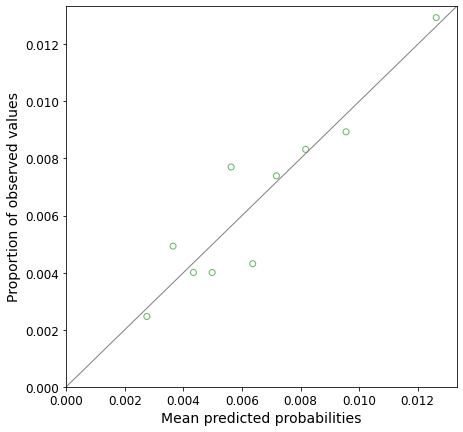

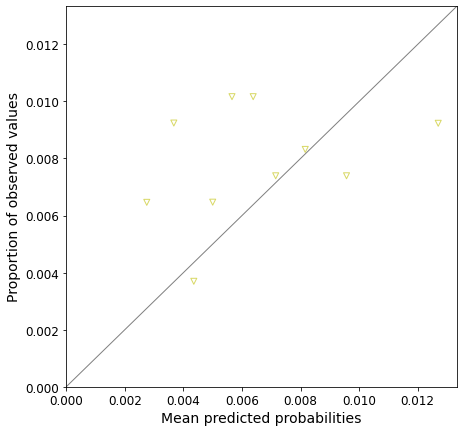

In [53]:
#data prep
data, data_uti_no_abs_incdt_enc = cox_data_prep(data_uti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_incdt', data_uti_no_abs_incdt)

try:
    #build cox model 
    cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test = cox_model_build('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_no_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_incdt.csv', data_uti_no_abs_incdt_enc, data_uti_no_abs_incdt, 'sum_betas_cph_uti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_no_abs_incdt, 'event_uti_admitted', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, 'event_uti_admitted', data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_incdt_train.jpg', 'calibration_cph_uti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_no_abs_incdt, 'uti', 'no_abs_incdt', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident uti with antibiotics

<lifelines.CoxPHFitter: fitted with 3571 total observations, 3546 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3571
number of events observed = 25
   partial log-likelihood = -185.79
         time fit was run = 2022-11-29 13:11:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.05       0.35       0.57            -2.17             0.08                 0.11                 1.08
CCI_cat[T.medium]               -0.46       0.63       0.58            -1.59             0.67                 0.20                 1.95
CCI_cat[T.high]                 -0.39       0.67       0.68            -1.74             0.95                 0.18                 2.58
CCI_cat[T.very_high]            -0.51       0.60       0.62            -1.72             0.71                 0.18                 2.02
age_cat[T.25_34]                -0.01       0.99       0.83            -1.63             1.61                 0.20                 5.00
age_cat[T.35_44]                 0.27       1.32       0.77            -1.24             1.79                 0.29                 5.96
age_cat[T.45_54]                 0.41       1.50       0.74            -1.04             1.86                 0.35                 6.42
age_cat[T.55_64]                 0.18       1.20       0.83            -1.45             1.81                 0.23                 6.14
age_cat[T.65_74]                 0.13       1.13       0.83            -1.50             1.75                 0.22                 5.73
age_cat[T.75_more]               0.38       1.47       0.77            -1.13             1.90                 0.32                 6.69
antibacterial_brit               0.01       1.01       0.15            -0.27             0.30                 0.76                 1.35
bmi_cat[T.obese]                 1.02       2.77       1.04            -1.01             3.05                 0.36                21.13
bmi_cat[T.overweight]            0.94       2.57       1.16            -1.33             3.22                 0.26                25.04
bmi_cat[T.underweight]         -15.10       0.00    2932.70         -5763.09          5732.89                 0.00                  inf
bmi_cat[T.unknown]               0.59       1.80       1.10            -1.57             2.75                 0.21                15.60
ethnicity[T.unknown]            -1.04       0.35       0.74            -2.49             0.41                 0.08                 1.50
ethnicity[T.white]              -0.06       0.95       0.52            -1.07             0.96                 0.34                 2.61
flu_vaccine[T.yes]              -0.26       0.77       0.75            -1.72             1.20                 0.18                 3.32
imd[T.medium]                    0.58       1.79       0.62            -0.64             1.81                 0.53                 6.09
imd[T.unaffluent]                0.33       1.39       0.68            -1.00             1.67                 0.37                 5.29
imd[T.unknown]                   0.62       1.86       0.89            -1.12             2.36                 0.33                10.57
imd[T.very_affluent]            -0.24       0.79       0.77            -1.75             1.27                 0.17                 3.57
imd[T.very_unaffluent]          -0.27       0.76       0.77            -1.78             1.23                 0.17                 3.43
region[T.east_midlands]         -0.05       0.95       0.53            -1.08             0.98                 0.34                 2.67
region[T.london]                -2.09       0.12       0.80            -3.6

12790


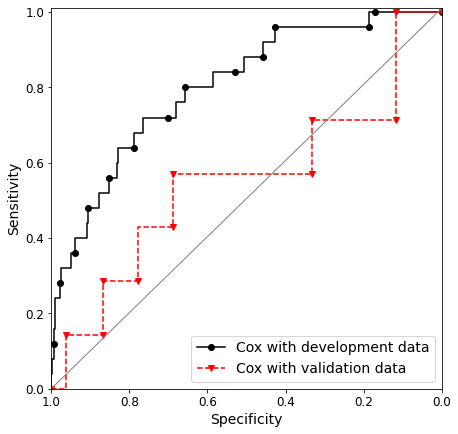

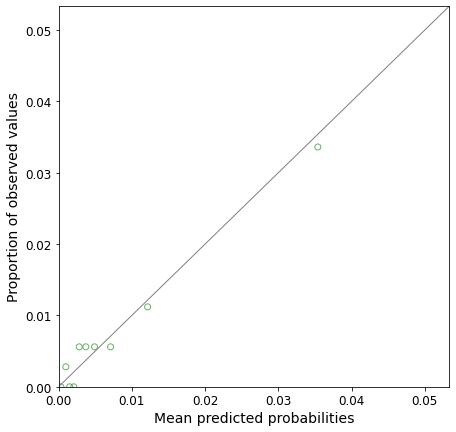

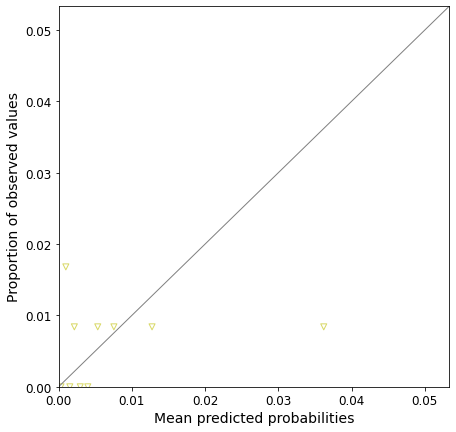

In [54]:
#data prep
data, data_uti_abs_incdt_enc = cox_data_prep(data_uti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_incdt', data_uti_abs_incdt)

try:
    #build cox model 
    cph_uti_abs_incdt, data_uti_abs_incdt_train, data_uti_abs_incdt_test = cox_model_build('uti', 'abs_incdt', data_uti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_incdt.csv', data_uti_abs_incdt_enc, data_uti_abs_incdt, 'sum_betas_cph_uti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_abs_incdt, 'event_uti_admitted', data_uti_abs_incdt_train, data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_abs_incdt, data_uti_abs_incdt_train, 'event_uti_admitted', data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_incdt_train.jpg', 'calibration_cph_uti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_abs_incdt, 'uti', 'abs_incdt', data_uti_abs_incdt_train, data_uti_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 3636 total observations, 3614 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3636
number of events observed = 22
   partial log-likelihood = -146.42
         time fit was run = 2022-11-29 13:11:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.72            -1.38             1.45                 0.25                 4.27
CCI_cat[T.medium]               -0.67       0.51       0.92            -2.48             1.14                 0.08                 3.14
CCI_cat[T.high]                  0.37       1.45       0.84            -1.27             2.01                 0.28                 7.49
CCI_cat[T.very_high]             1.22       3.38       0.70            -0.16             2.60                 0.85                13.40
age_cat[T.25_34]                -1.28       0.28       1.13            -3.50             0.94                 0.03                 2.57
age_cat[T.35_44]                -0.01       0.99       0.73            -1.45             1.42                 0.24                 4.14
age_cat[T.45_54]                -0.39       0.68       0.79            -1.93             1.16                 0.14                 3.19
age_cat[T.55_64]                -0.17       0.84       0.73            -1.60             1.26                 0.20                 3.51
age_cat[T.65_74]                 0.68       1.97       0.68            -0.65             2.00                 0.52                 7.40
age_cat[T.75_more]             -18.42       0.00    4684.29         -9199.45          9162.61                 0.00                  inf
antibacterial_brit               0.35       1.41       0.15             0.05             0.64                 1.05                 1.90
bmi_cat[T.obese]                -0.42       0.66       0.67            -1.74             0.90                 0.18                 2.46
bmi_cat[T.overweight]          -18.61       0.00    4578.98         -8993.24          8956.03                 0.00                  inf
bmi_cat[T.underweight]          -0.77       0.46       1.24            -3.20             1.66                 0.04                 5.28
bmi_cat[T.unknown]              -0.51       0.60       0.75            -1.99             0.97                 0.14                 2.63
ethnicity[T.unknown]             0.08       1.08       0.65            -1.19             1.35                 0.30                 3.84
ethnicity[T.white]              -0.29       0.75       0.61            -1.48             0.91                 0.23                 2.49
flu_vaccine[T.yes]             -18.17       0.00    5069.18         -9953.57          9917.24                 0.00                  inf
imd[T.medium]                    0.55       1.73       0.60            -0.62             1.72                 0.54                 5.57
imd[T.unaffluent]               -1.54       0.21       1.10            -3.70             0.62                 0.02                 1.86
imd[T.unknown]                  -0.19       0.82       1.11            -2.37             1.98                 0.09                 7.27
imd[T.very_affluent]             0.31       1.36       0.62            -0.90             1.51                 0.40                 4.55
imd[T.very_unaffluent]          -1.47       0.23       1.10            -3.63             0.70                 0.03                 2.01
region[T.east_midlands]          0.82       2.28       1.24            -1.62             3.26                 0.20                26.14
region[T.london]                 1.28       3.58       1.08            -0.8

12812


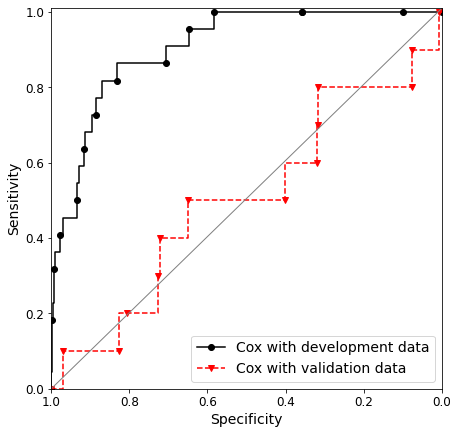

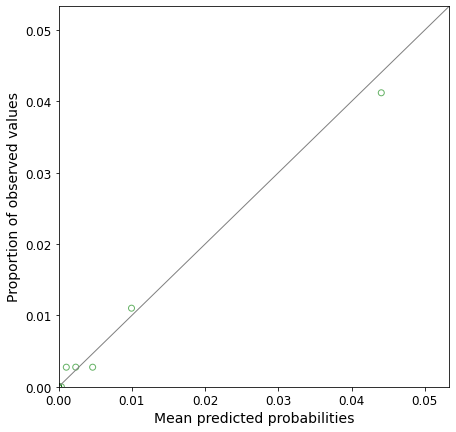

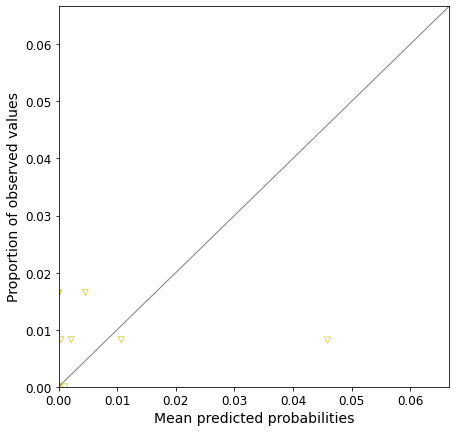

In [55]:
#data prep
data, data_uti_no_abs_prevl_enc = cox_data_prep(data_uti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_prevl', data_uti_no_abs_prevl)

try:
    #build cox model 
    cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test = cox_model_build('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_no_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_prevl.csv', data_uti_no_abs_prevl_enc, data_uti_no_abs_prevl, 'sum_betas_cph_uti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_no_abs_prevl, 'event_uti_admitted', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, 'event_uti_admitted', data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_prevl_train.jpg', 'calibration_cph_uti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_no_abs_prevl, 'uti', 'no_abs_prevl', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent uti with antibiotics

<lifelines.CoxPHFitter: fitted with 409 total observations, 407 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 409
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-11-29 13:11:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   4.38      79.79    5979.22        -11714.69         11723.44                 0.00                  inf
CCI_cat[T.medium]               13.23   5.60e+05    5594.41        -10951.60         10978.07                 0.00                  inf
CCI_cat[T.high]                 -3.79       0.02    7586.03        -14872.13         14864.55                 0.00                  inf
CCI_cat[T.very_high]            -1.27       0.28   10541.34        -20661.93         20659.39                 0.00                  inf
age_cat[T.25_34]                15.40   4.87e+06    4915.75         -9619.29          9650.09                 0.00                  inf
age_cat[T.35_44]                 2.44      11.46    7257.23        -14221.47         14226.35                 0.00                  inf
age_cat[T.45_54]                 0.63       1.88    6114.50        -11983.56         11984.83                 0.00                  inf
age_cat[T.55_64]                -5.26       0.01   10843.82        -21258.76         21248.24                 0.00                  inf
age_cat[T.65_74]                -8.98       0.00    5910.67        -11593.68         11575.72                 0.00                  inf
age_cat[T.75_more]               4.92     137.20    6068.63        -11889.38         11899.23                 0.00                  inf
antibacterial_brit              -2.04       0.13     951.61         -1867.17          1863.08                 0.00                  inf
bmi_cat[T.obese]                 5.55     257.14    6358.67        -12457.21         12468.31                 0.00                  inf
bmi_cat[T.overweight]            4.24      69.32    7979.60        -15635.49         15643.97                 0.00                  inf
bmi_cat[T.underweight]          -3.40       0.03    6866.54        -13461.57         13454.77                 0.00                  inf
bmi_cat[T.unknown]               3.93      50.81    6038.41        -11831.14         11839.00                 0.00                  inf
ethnicity[T.unknown]             8.81    6697.28    6252.84        -12246.54         12264.16                 0.00                  inf
ethnicity[T.white]               3.88      48.42    7053.62        -13820.96         13828.72                 0.00                  inf
flu_vaccine[T.yes]               4.53      92.95    6424.95        -12588.15         12597.21                 0.00                  inf
imd[T.medium]                    8.72    6154.67    4533.47         -8876.72          8894.17                 0.00                  inf
imd[T.unaffluent]               -3.83       0.02    6593.47        -12926.80         12919.13                 0.00                  inf
imd[T.unknown]                  -1.22       0.29   13070.97        -25619.84         25617.40                 0.00                  inf
imd[T.very_affluent]             5.45     232.48    6376.39        -12492.05         12502.94                 0.00                  inf
imd[T.very_unaffluent]          18.97   1.73e+08    4576.43         -8950.67          8988.60                 0.00                  inf
region[T.east_midlands]         -1.33       0.26   10689.88        -20953.11         20950.45                 0.00                  inf
region[T.london]                 9.41   12218.73    5165.64        -10115.07     

13172


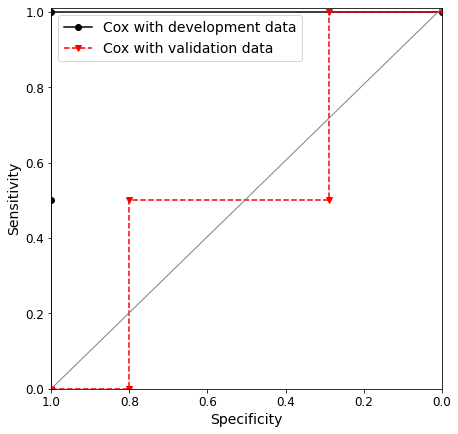

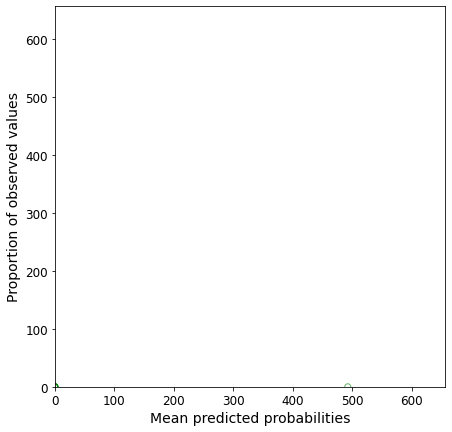

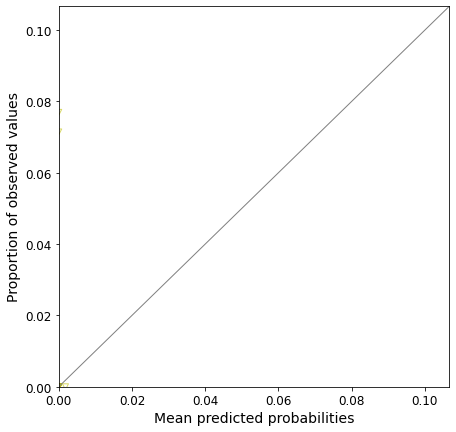

In [56]:
#data prep
data, data_uti_abs_prevl_enc = cox_data_prep(data_uti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_prevl', data_uti_abs_prevl)

try:
    #build cox model 
    cph_uti_abs_prevl, data_uti_abs_prevl_train, data_uti_abs_prevl_test = cox_model_build('uti', 'abs_prevl', data_uti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_prevl.csv', data_uti_abs_prevl_enc, data_uti_abs_prevl, 'sum_betas_cph_uti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_abs_prevl, 'event_uti_admitted', data_uti_abs_prevl_train, data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_abs_prevl, data_uti_abs_prevl_train, 'event_uti_admitted', data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_prevl_train.jpg', 'calibration_cph_uti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_abs_prevl, 'uti', 'abs_prevl', data_uti_abs_prevl_train, data_uti_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident uti

In [57]:
#data prep
data, data_uti_incdt_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'incdt', data_uti_incdt_enc)
make_summary_table_hosped('uti', 'incdt', data_uti_incdt)

try:
    cph_uti_incdt, data_uti_incdt_train, data_uti_incdt_test = cox_model_abs_build('uti', 'incdt', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt, 'uti', 'incdt', data_uti_incdt_train, data_uti_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36036 total observations, 35786 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 36036
number of events observed = 250
   partial log-likelihood = -2600.87
         time fit was run = 2022-11-29 13:11:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.19            -0.42             0.32                 0.66                 1.37
CCI_cat[T.medium]                0.20       1.22       0.20            -0.20             0.59                 0.82                 1.80
CCI_cat[T.high]                  0.02       1.02       0.25            -0.47             0.51                 0.62                 1.67
CCI_cat[T.very_high]             0.07       1.07       0.22            -0.36             0.49                 0.70                 1.63
age_cat[T.25_34]                -0.13       0.88       0.25            -0.62             0.36                 0.54                 1.43
age_cat[T.35_44]                -0.10       0.91       0.24            -0.58             0.38                 0.56                 1.47
age_cat[T.45_54]                 0.10       1.10       0.23            -0.36             0.56                 0.70                 1.74
age_cat[T.55_64]                 0.21       1.23       0.23            -0.24             0.65                 0.79                 1.92
age_cat[T.65_74]                -0.02       0.98       0.24            -0.49             0.45                 0.61                 1.57
age_cat[T.75_more]               0.01       1.01       0.24            -0.46             0.48                 0.63                 1.61
antibacterial_brit              -0.02       0.98       0.05            -0.11             0.06                 0.89                 1.07
bmi_cat[T.obese]                 0.15       1.16       0.26            -0.36             0.66                 0.70                 1.93
bmi_cat[T.overweight]            0.51       1.66       0.29            -0.07             1.08                 0.94                 2.94
bmi_cat[T.underweight]          -0.16       0.85       0.48            -1.09             0.77                 0.34                 2.17
bmi_cat[T.unknown]               0.17       1.19       0.27            -0.36             0.71                 0.69                 2.03
ethnicity[T.unknown]            -0.08       0.92       0.20            -0.47             0.32                 0.62                 1.37
ethnicity[T.white]              -0.07       0.93       0.18            -0.42             0.27                 0.66                 1.31
flu_vaccine[T.yes]              -0.42       0.66       0.25            -0.91             0.07                 0.40                 1.08
imd[T.medium]                    0.31       1.37       0.21            -0.09             0.72                 0.91                 2.06
imd[T.unaffluent]                0.31       1.37       0.21            -0.09             0.72                 0.91                 2.06
imd[T.unknown]                   0.13       1.14       0.33            -0.52             0.78                 0.60                 2.17
imd[T.very_affluent]             0.18       1.19       0.22            -0.25             0.60                 0.78                 1.82
imd[T.very_unaffluent]           0.07       1.07       0.22            -0.36             0.50                 0.69                 1.64
region[T.east_midlands]         -0.26       0.77       0.27            -0.78             0.27                 0.46                 1.31
region[T.london]                 0.09       1.09       0.22           

13034


### 5-6- hospital admission related to prevalent uti

In [58]:
#data prep
data, data_uti_prevl_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'prevl', data_uti_prevl_enc)
make_summary_table_hosped('uti', 'prevl', data_uti_prevl)

try:
    cph_uti_prevl, data_uti_prevl_train, data_uti_prevl_test = cox_model_abs_build('uti', 'prevl', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl, 'uti', 'prevl', data_uti_prevl_train, data_uti_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4045 total observations, 4017 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 4045
number of events observed = 28
   partial log-likelihood = -207.21
         time fit was run = 2022-11-29 13:11:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.60            -0.99             1.35                 0.37                 3.87
CCI_cat[T.medium]                0.25       1.28       0.65            -1.04             1.53                 0.36                 4.62
CCI_cat[T.high]                 -0.81       0.44       1.13            -3.02             1.40                 0.05                 4.04
CCI_cat[T.very_high]             0.78       2.17       0.64            -0.47             2.02                 0.62                 7.56
age_cat[T.25_34]                -0.37       0.69       0.65            -1.65             0.91                 0.19                 2.47
age_cat[T.35_44]                -0.48       0.62       0.65            -1.76             0.80                 0.17                 2.23
age_cat[T.45_54]                -1.16       0.31       0.82            -2.77             0.46                 0.06                 1.58
age_cat[T.55_64]                -1.18       0.31       0.82            -2.79             0.44                 0.06                 1.55
age_cat[T.65_74]                 0.19       1.21       0.57            -0.93             1.30                 0.40                 3.68
age_cat[T.75_more]              -0.73       0.48       0.71            -2.12             0.67                 0.12                 1.95
antibacterial_brit               0.25       1.29       0.13             0.00             0.50                 1.00                 1.65
bmi_cat[T.obese]                -0.19       0.83       0.64            -1.44             1.07                 0.24                 2.90
bmi_cat[T.overweight]          -18.32       0.00    4244.51         -8337.40          8300.77                 0.00                  inf
bmi_cat[T.underweight]          -0.58       0.56       1.19            -2.92             1.75                 0.05                 5.75
bmi_cat[T.unknown]              -0.39       0.68       0.70            -1.77             0.99                 0.17                 2.69
ethnicity[T.unknown]            -0.69       0.50       0.53            -1.71             0.34                 0.18                 1.41
ethnicity[T.white]              -1.07       0.34       0.46            -1.97            -0.18                 0.14                 0.84
flu_vaccine[T.yes]              -1.20       0.30       1.02            -3.20             0.81                 0.04                 2.25
imd[T.medium]                    0.22       1.24       0.62            -1.00             1.43                 0.37                 4.20
imd[T.unaffluent]               -0.44       0.65       0.74            -1.88             1.01                 0.15                 2.75
imd[T.unknown]                 -17.83       0.00    5174.20        -10159.07         10123.41                 0.00                  inf
imd[T.very_affluent]             0.39       1.48       0.59            -0.77             1.56                 0.46                 4.76
imd[T.very_unaffluent]           0.47       1.60       0.60            -0.70             1.64                 0.49                 5.15
region[T.east_midlands]          0.69       1.99       0.88            -1.03             2.41                 0.36                11.13
region[T.london]                 0.48       1.61       0.81            -1.1

13062


### 5-7- hospital admission related to incident uti with prescribed antibiotics categories

In [59]:
#data prep
data, data_uti_incdt_abs_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_abs, data_uti_incdt_abs_train, data_uti_incdt_abs_test = cox_model_ab_type_build('uti', 'incdt_ab_type', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_abs, 'uti', 'incdt_abs', data_uti_incdt_abs_train, data_uti_incdt_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36036 total observations, 35786 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 36036
number of events observed = 250
   partial log-likelihood = -2600.20
         time fit was run = 2022-11-29 13:11:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.19            -0.42             0.32                 0.66                 1.37
CCI_cat[T.medium]                0.20       1.22       0.20            -0.19             0.59                 0.82                 1.80
CCI_cat[T.high]                  0.02       1.02       0.25            -0.47             0.51                 0.62                 1.67
CCI_cat[T.very_high]             0.07       1.07       0.22            -0.36             0.49                 0.70                 1.63
ab_type_cat[T.Doxycycline]     -13.49       0.00    1295.13         -2551.91          2524.92                 0.00                  inf
ab_type_cat[T.no]                0.30       1.36       1.00            -1.66             2.27                 0.19                 9.68
ab_type_cat[T.other]             0.36       1.43       1.02            -1.64             2.36                 0.19                10.58
age_cat[T.25_34]                -0.13       0.88       0.25            -0.62             0.36                 0.54                 1.43
age_cat[T.35_44]                -0.10       0.91       0.24            -0.58             0.38                 0.56                 1.47
age_cat[T.45_54]                 0.10       1.10       0.23            -0.36             0.56                 0.70                 1.74
age_cat[T.55_64]                 0.21       1.23       0.23            -0.24             0.65                 0.79                 1.92
age_cat[T.65_74]                -0.02       0.98       0.24            -0.49             0.45                 0.61                 1.56
age_cat[T.75_more]               0.01       1.01       0.24            -0.46             0.47                 0.63                 1.61
antibacterial_brit              -0.02       0.98       0.05            -0.11             0.06                 0.89                 1.07
bmi_cat[T.obese]                 0.15       1.16       0.26            -0.36             0.66                 0.70                 1.93
bmi_cat[T.overweight]            0.51       1.66       0.29            -0.07             1.08                 0.94                 2.94
bmi_cat[T.underweight]          -0.16       0.86       0.48            -1.09             0.78                 0.34                 2.17
bmi_cat[T.unknown]               0.17       1.19       0.27            -0.36             0.71                 0.70                 2.03
ethnicity[T.unknown]            -0.08       0.93       0.20            -0.47             0.32                 0.62                 1.37
ethnicity[T.white]              -0.07       0.93       0.18            -0.42             0.27                 0.66                 1.31
flu_vaccine[T.yes]              -0.42       0.66       0.25            -0.91             0.08                 0.40                 1.08
imd[T.medium]                    0.31       1.37       0.21            -0.09             0.72                 0.91                 2.06
imd[T.unaffluent]                0.31       1.37       0.21            -0.09             0.72                 0.91                 2.06
imd[T.unknown]                   0.13       1.14       0.33            -0.52             0.77                 0.60                 2.17
imd[T.very_affluent]             0.17       1.19       0.22           

13610


### 5-8- hospital admission related to prevalent uti with prescribed antibiotics categories

In [60]:
#data prep
data, data_uti_prevl_abs_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_abs, data_uti_prevl_abs_train, data_uti_prevl_abs_test = cox_model_ab_type_build('uti', 'prevl_ab_type', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_abs, 'uti', 'prevl_abs', data_uti_prevl_abs_train, data_uti_prevl_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4045 total observations, 4017 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 4045
number of events observed = 28
   partial log-likelihood = -207.10
         time fit was run = 2022-11-29 13:11:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.60            -0.99             1.35                 0.37                 3.87
CCI_cat[T.medium]                0.25       1.28       0.65            -1.04             1.53                 0.36                 4.62
CCI_cat[T.high]                 -0.81       0.44       1.13            -3.02             1.40                 0.05                 4.04
CCI_cat[T.very_high]             0.78       2.18       0.64            -0.47             2.03                 0.63                 7.61
ab_type_cat[T.Doxycycline]      -0.75       0.47   48802.50        -95651.91         95650.40                 0.00                  inf
ab_type_cat[T.no]               17.15   2.80e+07   13346.40        -26141.31         26175.61                 0.00                  inf
ab_type_cat[T.other]            16.70   1.78e+07   13346.40        -26141.76         26175.15                 0.00                  inf
age_cat[T.25_34]                -0.37       0.69       0.65            -1.65             0.90                 0.19                 2.47
age_cat[T.35_44]                -0.48       0.62       0.65            -1.76             0.80                 0.17                 2.23
age_cat[T.45_54]                -1.16       0.31       0.82            -2.77             0.46                 0.06                 1.58
age_cat[T.55_64]                -1.18       0.31       0.82            -2.80             0.44                 0.06                 1.55
age_cat[T.65_74]                 0.19       1.21       0.57            -0.92             1.31                 0.40                 3.69
age_cat[T.75_more]              -0.72       0.49       0.71            -2.11             0.68                 0.12                 1.97
antibacterial_brit               0.25       1.28       0.13            -0.00             0.50                 1.00                 1.65
bmi_cat[T.obese]                -0.19       0.83       0.64            -1.44             1.07                 0.24                 2.91
bmi_cat[T.overweight]          -18.26       0.00    4124.66         -8102.44          8065.93                 0.00                  inf
bmi_cat[T.underweight]          -0.56       0.57       1.19            -2.89             1.78                 0.06                 5.91
bmi_cat[T.unknown]              -0.38       0.69       0.70            -1.76             1.00                 0.17                 2.72
ethnicity[T.unknown]            -0.68       0.50       0.53            -1.71             0.35                 0.18                 1.41
ethnicity[T.white]              -1.07       0.34       0.46            -1.97            -0.17                 0.14                 0.84
flu_vaccine[T.yes]              -1.20       0.30       1.02            -3.21             0.81                 0.04                 2.24
imd[T.medium]                    0.21       1.24       0.62            -1.00             1.43                 0.37                 4.18
imd[T.unaffluent]               -0.43       0.65       0.74            -1.88             1.01                 0.15                 2.75
imd[T.unknown]                 -17.76       0.00    5023.11         -9862.87          9827.35                 0.00                  inf
imd[T.very_affluent]             0.40       1.50       0.60            -0.7

13668


### 5-9- stratified by sex
#### 5-9-1- incident males

In [61]:
#data prep
data, data_uti_incdt_males_enc = cox_data_prep(data_uti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_males, data_uti_incdt_males_train, data_uti_incdt_males_test = cox_model_strat_sex_build('uti', 'incdt_males', data_uti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_males, 'uti', 'incdt_males', data_uti_incdt_males_train, data_uti_incdt_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17624 total observations, 17481 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17624
number of events observed = 143
   partial log-likelihood = -1373.31
         time fit was run = 2022-11-29 13:11:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.42       1.52       0.27            -0.10             0.95                 0.90                 2.57
CCI_cat[T.medium]                0.26       1.30       0.30            -0.33             0.85                 0.72                 2.35
CCI_cat[T.high]                  0.40       1.49       0.34            -0.26             1.07                 0.77                 2.91
CCI_cat[T.very_high]             0.56       1.76       0.30            -0.02             1.15                 0.98                 3.15
age_cat[T.25_34]                -0.09       0.91       0.30            -0.68             0.50                 0.51                 1.65
age_cat[T.35_44]                -0.22       0.80       0.32            -0.84             0.40                 0.43                 1.49
age_cat[T.45_54]                 0.03       1.03       0.29            -0.55             0.60                 0.58                 1.82
age_cat[T.55_64]                 0.01       1.01       0.30            -0.57             0.59                 0.57                 1.80
age_cat[T.65_74]                -0.41       0.66       0.33            -1.06             0.24                 0.35                 1.27
age_cat[T.75_more]              -0.14       0.87       0.31            -0.75             0.46                 0.47                 1.59
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.11
bmi_cat[T.obese]                 0.40       1.49       0.37            -0.33             1.13                 0.72                 3.09
bmi_cat[T.overweight]            0.87       2.39       0.41             0.07             1.67                 1.08                 5.31
bmi_cat[T.underweight]          -0.10       0.91       0.68            -1.43             1.23                 0.24                 3.43
bmi_cat[T.unknown]               0.24       1.27       0.40            -0.54             1.02                 0.59                 2.76
ethnicity[T.unknown]            -0.13       0.88       0.26            -0.64             0.39                 0.53                 1.47
ethnicity[T.white]              -0.15       0.86       0.23            -0.60             0.30                 0.55                 1.35
flu_vaccine[T.yes]              -0.52       0.59       0.34            -1.20             0.15                 0.30                 1.17
imd[T.medium]                    0.60       1.83       0.27             0.08             1.12                 1.09                 3.08
imd[T.unaffluent]                0.21       1.23       0.29            -0.36             0.78                 0.70                 2.18
imd[T.unknown]                   0.38       1.46       0.41            -0.43             1.19                 0.65                 3.29
imd[T.very_affluent]            -0.01       0.99       0.31            -0.61             0.59                 0.55                 1.81
imd[T.very_unaffluent]           0.17       1.19       0.29            -0.40             0.74                 0.67                 2.09
region[T.east_midlands]         -0.09       0.91       0.32            -0.71             0.53                 0.49                 1.70
region[T.london]                -0.46       0.63       0.29           

12773


#### 5-9-2- incident females

In [62]:
#data prep
data, data_uti_incdt_females_enc = cox_data_prep(data_uti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_females, data_uti_incdt_females_train, data_uti_incdt_females_test = cox_model_strat_sex_build('uti', 'incdt_females', data_uti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_females, 'uti', 'incdt_females', data_uti_incdt_females_train, data_uti_incdt_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18411 total observations, 18292 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 18411
number of events observed = 119
   partial log-likelihood = -1154.16
         time fit was run = 2022-11-29 13:11:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.33       0.72       0.26            -0.83             0.18                 0.44                 1.20
CCI_cat[T.medium]                0.06       1.06       0.27            -0.46             0.58                 0.63                 1.79
CCI_cat[T.high]                 -0.30       0.74       0.36            -1.00             0.41                 0.37                 1.50
CCI_cat[T.very_high]            -0.48       0.62       0.32            -1.11             0.16                 0.33                 1.17
age_cat[T.25_34]                 0.44       1.55       0.36            -0.26             1.14                 0.77                 3.12
age_cat[T.35_44]                 0.14       1.15       0.38            -0.60             0.88                 0.55                 2.42
age_cat[T.45_54]                -0.02       0.98       0.39            -0.79             0.75                 0.46                 2.12
age_cat[T.55_64]                 0.35       1.42       0.36            -0.35             1.06                 0.70                 2.88
age_cat[T.65_74]                 0.51       1.66       0.35            -0.17             1.19                 0.84                 3.29
age_cat[T.75_more]               0.17       1.19       0.37            -0.56             0.90                 0.57                 2.47
antibacterial_brit              -0.03       0.97       0.07            -0.15             0.10                 0.86                 1.11
bmi_cat[T.obese]                 0.05       1.05       0.34            -0.62             0.72                 0.54                 2.05
bmi_cat[T.overweight]           -0.28       0.76       0.45            -1.16             0.60                 0.31                 1.82
bmi_cat[T.underweight]          -0.65       0.52       0.78            -2.17             0.87                 0.11                 2.38
bmi_cat[T.unknown]               0.08       1.09       0.36            -0.63             0.79                 0.53                 2.21
ethnicity[T.unknown]            -0.29       0.75       0.30            -0.88             0.30                 0.41                 1.35
ethnicity[T.white]              -0.08       0.92       0.25            -0.58             0.41                 0.56                 1.51
flu_vaccine[T.yes]              -0.37       0.69       0.37            -1.08             0.35                 0.34                 1.42
imd[T.medium]                    0.25       1.29       0.32            -0.38             0.88                 0.68                 2.42
imd[T.unaffluent]                0.31       1.36       0.32            -0.32             0.93                 0.72                 2.54
imd[T.unknown]                   0.65       1.92       0.41            -0.16             1.46                 0.86                 4.32
imd[T.very_affluent]             0.41       1.51       0.31            -0.21             1.03                 0.81                 2.80
imd[T.very_unaffluent]           0.29       1.34       0.32            -0.33             0.92                 0.72                 2.51
region[T.east_midlands]         -0.77       0.46       0.41            -1.57             0.03                 0.21                 1.03
region[T.london]                -0.22       0.80       0.30           

12772


#### 5-9-3- prevalent males

In [63]:
#data prep
data, data_uti_prevl_males_enc = cox_data_prep(data_uti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_males, data_uti_prevl_males_train, data_uti_prevl_males_test = cox_model_strat_sex_build('uti', 'prevl_males', data_uti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_uti_prevl_males, 'uti', 'prevl_males', data_uti_prevl_males_train, data_uti_prevl_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1971 total observations, 1952 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1971
number of events observed = 19
   partial log-likelihood = -121.27
         time fit was run = 2022-11-29 13:11:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.82            -1.24             1.96                 0.29                 7.09
CCI_cat[T.medium]                0.19       1.21       0.89            -1.55             1.92                 0.21                 6.84
CCI_cat[T.high]                  0.35       1.42       1.04            -1.69             2.39                 0.18                10.92
CCI_cat[T.very_high]             0.56       1.75       0.93            -1.27             2.39                 0.28                10.88
age_cat[T.25_34]                 0.81       2.25       1.26            -1.66             3.28                 0.19                26.60
age_cat[T.35_44]                 1.04       2.82       1.17            -1.26             3.33                 0.28                28.07
age_cat[T.45_54]                 0.58       1.79       1.26            -1.89             3.06                 0.15                21.27
age_cat[T.55_64]                 1.31       3.71       1.14            -0.93             3.55                 0.40                34.75
age_cat[T.65_74]                 1.50       4.50       1.15            -0.75             3.76                 0.47                42.88
age_cat[T.75_more]               1.33       3.76       1.18            -0.99             3.64                 0.37                38.16
antibacterial_brit               0.11       1.12       0.16            -0.21             0.43                 0.81                 1.54
bmi_cat[T.obese]                -1.72       0.18       0.58            -2.86            -0.58                 0.06                 0.56
bmi_cat[T.overweight]          -19.95       0.00    6488.33        -12736.84         12696.95                 0.00                  inf
bmi_cat[T.underweight]         -20.12       0.00   14023.44        -27505.56         27465.32                 0.00                  inf
bmi_cat[T.unknown]              -1.11       0.33       0.62            -2.32             0.10                 0.10                 1.11
ethnicity[T.unknown]             0.42       1.52       0.82            -1.19             2.02                 0.30                 7.57
ethnicity[T.white]               0.05       1.05       0.80            -1.51             1.61                 0.22                 5.01
flu_vaccine[T.yes]             -18.17       0.00    5762.67        -11312.79         11276.44                 0.00                  inf
imd[T.medium]                    1.05       2.86       0.86            -0.63             2.74                 0.53                15.42
imd[T.unaffluent]                0.25       1.28       0.94            -1.59             2.08                 0.20                 8.02
imd[T.unknown]                   0.82       2.26       1.25            -1.64             3.27                 0.19                26.36
imd[T.very_affluent]             1.09       2.97       0.85            -0.57             2.75                 0.56                15.67
imd[T.very_unaffluent]           0.04       1.04       1.01            -1.95             2.03                 0.14                 7.58
region[T.east_midlands]          1.20       3.33       1.18            -1.12             3.52                 0.33                33.86
region[T.london]                 1.35       3.87       1.11            -0.8

12816


#### 5-9-4- prevalent females

In [64]:
try:
    #data prep
    data, data_uti_prevl_females_enc = cox_data_prep(data_uti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

    #cox model
    cph_uti_prevl_females, data_uti_prevl_females_train, data_uti_prevl_females_test = cox_model_strat_sex_build('uti', 'prevl_females', data_uti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_females, 'uti', 'prevl_females', data_uti_prevl_females_train, data_uti_prevl_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2074 total observations, 2067 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 2074
number of events observed = 7
   partial log-likelihood = -30.59
         time fit was run = 2022-11-29 13:11:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       1.35            -2.50             2.78                 0.08                16.04
CCI_cat[T.medium]                0.98       2.67       1.34            -1.65             3.62                 0.19                37.18
CCI_cat[T.high]                  0.33       1.39       1.52            -2.65             3.30                 0.07                27.14
CCI_cat[T.very_high]             0.48       1.62       1.65            -2.75             3.72                 0.06                41.19
age_cat[T.25_34]                -1.04       0.35       1.03            -3.07             0.98                 0.05                 2.67
age_cat[T.35_44]               -19.79       0.00    9594.14        -18823.95         18784.37                 0.00                  inf
age_cat[T.45_54]               -19.82       0.00   10878.47        -21341.22         21301.58                 0.00                  inf
age_cat[T.55_64]               -19.84       0.00   11373.13        -22310.77         22271.10                 0.00                  inf
age_cat[T.65_74]               -19.79       0.00   11224.98        -22020.33         21980.76                 0.00                  inf
age_cat[T.75_more]              -0.89       0.41       1.18            -3.19             1.42                 0.04                 4.13
antibacterial_brit              -0.02       0.98       0.33            -0.67             0.62                 0.51                 1.86
bmi_cat[T.obese]                18.06   7.00e+07    6239.69        -12211.51         12247.64                 0.00                  inf
bmi_cat[T.overweight]            0.04       1.04   12761.49        -25012.03         25012.11                 0.00                  inf
bmi_cat[T.underweight]          -1.33       0.26   24127.59        -47290.53         47287.87                 0.00                  inf
bmi_cat[T.unknown]              16.97   2.34e+07    6239.69        -12212.61         12246.54                 0.00                  inf
ethnicity[T.unknown]           -18.43       0.00    6590.12        -12934.82         12897.96                 0.00                  inf
ethnicity[T.white]               0.04       1.04       1.33            -2.56             2.64                 0.08                13.95
flu_vaccine[T.yes]               0.71       2.03       1.30            -1.84             3.26                 0.16                25.95
imd[T.medium]                  -19.83       0.00   13963.14        -27387.08         27347.42                 0.00                  inf
imd[T.unaffluent]              -19.91       0.00   13549.75        -26576.93         26537.11                 0.00                  inf
imd[T.unknown]                 -19.56       0.00   27615.69        -54145.33         54106.20                 0.00                  inf
imd[T.very_affluent]           -19.58       0.00   13573.93        -26623.99         26584.83                 0.00                  inf
imd[T.very_unaffluent]           0.74       2.09       1.01            -1.23             2.71                 0.29                15.00
region[T.east_midlands]         -0.27       0.77       1.63            -3.46             2.92                 0.03                18.60
region[T.london]                -0.86       0.42       1.55            -3.90 

12987


### 5-10- stratified by age category
#### 5-10-1- incident

In [65]:
#data prep
data, data_uti_incdt_15_24_enc = cox_data_prep(data_uti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_15_24, data_uti_incdt_15_24_train, data_uti_incdt_15_24_test = cox_model_strat_age_build('uti', 'incdt_15_24', data_uti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_15_24, 'uti', 'incdt_15_24', data_uti_incdt_15_24_train, data_uti_incdt_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5103 total observations, 5066 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5103
number of events observed = 37
   partial log-likelihood = -296.63
         time fit was run = 2022-11-29 13:11:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.54            -0.82             1.28                 0.44                 3.60
CCI_cat[T.medium]                0.33       1.39       0.57            -0.79             1.45                 0.45                 4.27
CCI_cat[T.high]                  0.60       1.82       0.64            -0.65             1.85                 0.52                 6.34
CCI_cat[T.very_high]             0.48       1.61       0.59            -0.67             1.63                 0.51                 5.11
antibacterial_brit              -0.14       0.87       0.12            -0.38             0.10                 0.68                 1.10
bmi_cat[T.obese]                 0.84       2.31       0.74            -0.61             2.28                 0.54                 9.79
bmi_cat[T.overweight]            0.88       2.42       0.82            -0.72             2.49                 0.49                12.05
bmi_cat[T.underweight]         -15.35       0.00    2522.14         -4958.64          4927.95                 0.00                  inf
bmi_cat[T.unknown]              -0.34       0.71       0.87            -2.04             1.36                 0.13                 3.90
ethnicity[T.unknown]            -1.04       0.35       0.52            -2.05            -0.02                 0.13                 0.98
ethnicity[T.white]              -0.60       0.55       0.39            -1.36             0.16                 0.26                 1.18
flu_vaccine[T.yes]              -0.68       0.51       0.73            -2.11             0.75                 0.12                 2.12
imd[T.medium]                    1.20       3.32       0.66            -0.10             2.49                 0.91                12.12
imd[T.unaffluent]                1.07       2.92       0.67            -0.24             2.38                 0.79                10.82
imd[T.unknown]                   0.84       2.31       0.92            -0.96             2.63                 0.38                13.94
imd[T.very_affluent]            -0.32       0.73       0.91            -2.11             1.47                 0.12                 4.35
imd[T.very_unaffluent]           1.36       3.88       0.65             0.08             2.64                 1.08                13.99
region[T.east_midlands]         -0.01       0.99       0.71            -1.40             1.38                 0.25                 3.97
region[T.london]                 0.23       1.25       0.59            -0.94             1.39                 0.39                 4.01
region[T.north_east]            -0.67       0.51       0.87            -2.37             1.03                 0.09                 2.80
region[T.north_west]            -0.54       0.58       0.87            -2.24             1.17                 0.11                 3.22
region[T.south_east]             0.05       1.05       0.71            -1.35             1.44                 0.26                 4.21
region[T.south_west]            -0.75       0.47       0.87            -2.45             0.95                 0.09                 2.59
region[T.west_midlands]         -0.00       1.00       0.71            -1.39             1.39                 0.25                 4.01
region[T.yorkshire]              0.26       1.29       0.68            -1.0

11401


In [66]:
#data prep
data, data_uti_incdt_25_34_enc = cox_data_prep(data_uti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_25_34, data_uti_incdt_25_34_train, data_uti_incdt_25_34_test = cox_model_strat_age_build('uti', 'incdt_25_34', data_uti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_25_34, 'uti', 'incdt_25_34', data_uti_incdt_25_34_train, data_uti_incdt_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5075 total observations, 5043 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5075
number of events observed = 32
   partial log-likelihood = -241.17
         time fit was run = 2022-11-29 13:11:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.72       0.48       0.48            -1.66             0.21                 0.19                 1.23
CCI_cat[T.medium]               -0.15       0.86       0.52            -1.16             0.86                 0.31                 2.36
CCI_cat[T.high]                 -1.12       0.33       0.79            -2.66             0.42                 0.07                 1.53
CCI_cat[T.very_high]            -0.46       0.63       0.56            -1.57             0.65                 0.21                 1.91
antibacterial_brit              -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
bmi_cat[T.obese]                18.06   6.96e+07    4469.84         -8742.66          8778.78                 0.00                  inf
bmi_cat[T.overweight]           18.39   9.74e+07    4469.84         -8742.33          8779.11                 0.00                  inf
bmi_cat[T.underweight]          18.21   8.06e+07    4469.84         -8742.51          8778.93                 0.00                  inf
bmi_cat[T.unknown]              17.11   2.68e+07    4469.84         -8743.61          8777.83                 0.00                  inf
ethnicity[T.unknown]            -0.50       0.61       0.53            -1.53             0.53                 0.22                 1.70
ethnicity[T.white]              -0.63       0.53       0.46            -1.52             0.27                 0.22                 1.31
flu_vaccine[T.yes]             -17.97       0.00    4358.27         -8560.03          8524.10                 0.00                  inf
imd[T.medium]                    0.21       1.24       0.56            -0.89             1.31                 0.41                 3.71
imd[T.unaffluent]                0.26       1.30       0.56            -0.84             1.36                 0.43                 3.89
imd[T.unknown]                   1.16       3.18       0.62            -0.05             2.37                 0.95                10.66
imd[T.very_affluent]            -1.06       0.35       0.82            -2.66             0.55                 0.07                 1.73
imd[T.very_unaffluent]          -0.22       0.80       0.61            -1.42             0.97                 0.24                 2.64
region[T.east_midlands]         -0.75       0.47       0.55            -1.83             0.33                 0.16                 1.40
region[T.london]                -0.84       0.43       0.48            -1.78             0.10                 0.17                 1.10
region[T.north_east]            -2.25       0.11       1.05            -4.31            -0.19                 0.01                 0.83
region[T.north_west]            -1.24       0.29       0.66            -2.54             0.05                 0.08                 1.06
region[T.south_east]            -2.38       0.09       1.05            -4.44            -0.32                 0.01                 0.73
region[T.south_west]            -1.52       0.22       0.78            -3.04             0.01                 0.05                 1.01
region[T.west_midlands]        -19.26       0.00    4974.13         -9768.37          9729.85                 0.00                  inf
region[T.yorkshire]             -1.55       0.21       0.78            -3.0

11477


In [67]:
#data prep
data, data_uti_incdt_35_44_enc = cox_data_prep(data_uti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_35_44, data_uti_incdt_35_44_train, data_uti_incdt_35_44_test = cox_model_strat_age_build('uti', 'incdt_35_44', data_uti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_35_44, 'uti', 'incdt_35_44', data_uti_incdt_35_44_train, data_uti_incdt_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5139 total observations, 5109 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5139
number of events observed = 30
   partial log-likelihood = -241.82
         time fit was run = 2022-11-29 13:11:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.42       1.52       0.59            -0.73             1.57                 0.48                 4.79
CCI_cat[T.medium]                0.71       2.03       0.60            -0.48             1.89                 0.62                 6.63
CCI_cat[T.high]                  0.04       1.04       0.87            -1.67             1.74                 0.19                 5.71
CCI_cat[T.very_high]             0.19       1.20       0.71            -1.21             1.58                 0.30                 4.84
antibacterial_brit               0.01       1.01       0.13            -0.25             0.27                 0.78                 1.31
bmi_cat[T.obese]                -0.54       0.59       0.66            -1.82             0.75                 0.16                 2.12
bmi_cat[T.overweight]            0.23       1.26       0.74            -1.21             1.68                 0.30                 5.35
bmi_cat[T.underweight]           0.04       1.04       1.16            -2.24             2.32                 0.11                10.17
bmi_cat[T.unknown]               0.06       1.06       0.66            -1.24             1.36                 0.29                 3.88
ethnicity[T.unknown]             0.47       1.61       0.68            -0.86             1.81                 0.42                 6.10
ethnicity[T.white]               0.41       1.51       0.63            -0.81             1.64                 0.44                 5.14
flu_vaccine[T.yes]               1.03       2.80       0.44             0.18             1.88                 1.19                 6.58
imd[T.medium]                    0.16       1.17       0.64            -1.09             1.40                 0.34                 4.07
imd[T.unaffluent]               -0.14       0.87       0.67            -1.47             1.18                 0.23                 3.25
imd[T.unknown]                   0.89       2.44       0.74            -0.55             2.33                 0.58                10.29
imd[T.very_affluent]             0.65       1.92       0.58            -0.48             1.78                 0.62                 5.93
imd[T.very_unaffluent]           0.01       1.01       0.64            -1.24             1.26                 0.29                 3.54
region[T.east_midlands]          0.05       1.05       0.71            -1.35             1.44                 0.26                 4.22
region[T.london]                -0.23       0.79       0.65            -1.50             1.04                 0.22                 2.82
region[T.north_east]            -0.64       0.53       0.87            -2.34             1.07                 0.10                 2.91
region[T.north_west]            -0.64       0.53       0.87            -2.34             1.07                 0.10                 2.90
region[T.south_east]            -1.35       0.26       1.12            -3.55             0.84                 0.03                 2.32
region[T.south_west]            -1.34       0.26       1.12            -3.53             0.86                 0.03                 2.36
region[T.west_midlands]          0.35       1.42       0.67            -0.97             1.67                 0.38                 5.31
region[T.yorkshire]              0.26       1.30       0.67            -1.0

11384


In [68]:
#data prep
data, data_uti_incdt_45_54_enc = cox_data_prep(data_uti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_45_54, data_uti_incdt_45_54_train, data_uti_incdt_45_54_test = cox_model_strat_age_build('uti', 'incdt_45_54', data_uti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_45_54, 'uti', 'incdt_45_54', data_uti_incdt_45_54_train, data_uti_incdt_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5186 total observations, 5147 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5186
number of events observed = 39
   partial log-likelihood = -311.16
         time fit was run = 2022-11-29 13:11:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.93       0.43            -0.91             0.76                 0.40                 2.13
CCI_cat[T.medium]               -0.33       0.72       0.51            -1.33             0.66                 0.26                 1.94
CCI_cat[T.high]                 -0.79       0.45       0.79            -2.33             0.75                 0.10                 2.12
CCI_cat[T.very_high]            -0.33       0.72       0.53            -1.38             0.71                 0.25                 2.03
antibacterial_brit               0.12       1.13       0.11            -0.09             0.33                 0.91                 1.40
bmi_cat[T.obese]                -0.40       0.67       0.55            -1.49             0.68                 0.23                 1.97
bmi_cat[T.overweight]           -0.78       0.46       0.77            -2.29             0.74                 0.10                 2.09
bmi_cat[T.underweight]           0.44       1.55       0.77            -1.07             1.95                 0.34                 7.06
bmi_cat[T.unknown]              -0.68       0.51       0.62            -1.89             0.54                 0.15                 1.71
ethnicity[T.unknown]             0.79       2.20       0.58            -0.34             1.92                 0.71                 6.82
ethnicity[T.white]               0.48       1.61       0.55            -0.59             1.55                 0.55                 4.70
flu_vaccine[T.yes]              -1.35       0.26       1.02            -3.34             0.64                 0.04                 1.90
imd[T.medium]                    0.06       1.06       0.49            -0.91             1.02                 0.40                 2.77
imd[T.unaffluent]                0.27       1.31       0.49            -0.69             1.23                 0.50                 3.43
imd[T.unknown]                  -0.74       0.48       1.06            -2.82             1.35                 0.06                 3.85
imd[T.very_affluent]            -0.26       0.77       0.55            -1.33             0.81                 0.26                 2.24
imd[T.very_unaffluent]          -0.28       0.76       0.54            -1.34             0.79                 0.26                 2.20
region[T.east_midlands]         -1.19       0.30       0.82            -2.80             0.42                 0.06                 1.52
region[T.london]                -0.10       0.91       0.51            -1.10             0.91                 0.33                 2.48
region[T.north_east]            -0.12       0.89       0.61            -1.32             1.08                 0.27                 2.95
region[T.north_west]            -0.23       0.79       0.61            -1.43             0.97                 0.24                 2.64
region[T.south_east]            -0.36       0.70       0.65            -1.64             0.92                 0.19                 2.51
region[T.south_west]            -1.69       0.18       1.08            -3.81             0.43                 0.02                 1.54
region[T.west_midlands]         -0.61       0.54       0.71            -2.00             0.79                 0.13                 2.20
region[T.yorkshire]             -1.00       0.37       0.82            -2.6

11436


In [69]:
#data prep
data, data_uti_incdt_55_64_enc = cox_data_prep(data_uti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_55_64, data_uti_incdt_55_64_train, data_uti_incdt_55_64_test = cox_model_strat_age_build('uti', 'incdt_55_64', data_uti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_55_64, 'uti', 'incdt_55_64', data_uti_incdt_55_64_train, data_uti_incdt_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5159 total observations, 5120 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5159
number of events observed = 39
   partial log-likelihood = -315.06
         time fit was run = 2022-11-29 13:11:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.30       1.35       0.48            -0.65             1.24                 0.52                 3.46
CCI_cat[T.medium]               -0.12       0.89       0.58            -1.26             1.02                 0.28                 2.77
CCI_cat[T.high]                 -0.65       0.52       0.82            -2.25             0.96                 0.11                 2.61
CCI_cat[T.very_high]             0.44       1.55       0.53            -0.60             1.48                 0.55                 4.40
antibacterial_brit              -0.00       1.00       0.11            -0.22             0.22                 0.80                 1.25
bmi_cat[T.obese]                 0.07       1.07       0.62            -1.14             1.28                 0.32                 3.61
bmi_cat[T.overweight]           -0.43       0.65       0.82            -2.04             1.18                 0.13                 3.25
bmi_cat[T.underweight]          -0.24       0.79       1.16            -2.51             2.03                 0.08                 7.61
bmi_cat[T.unknown]              -0.04       0.96       0.66            -1.34             1.26                 0.26                 3.52
ethnicity[T.unknown]            -0.02       0.98       0.48            -0.96             0.92                 0.38                 2.52
ethnicity[T.white]              -0.41       0.67       0.44            -1.28             0.46                 0.28                 1.58
flu_vaccine[T.yes]               0.03       1.03       0.53            -1.01             1.07                 0.36                 2.91
imd[T.medium]                    1.03       2.81       0.67            -0.28             2.34                 0.76                10.42
imd[T.unaffluent]                1.09       2.98       0.67            -0.22             2.40                 0.80                11.02
imd[T.unknown]                   1.40       4.06       0.82            -0.21             3.01                 0.81                20.34
imd[T.very_affluent]             0.64       1.89       0.71            -0.75             2.03                 0.47                 7.58
imd[T.very_unaffluent]           1.02       2.77       0.67            -0.29             2.33                 0.75                10.25
region[T.east_midlands]         -0.05       0.96       0.71            -1.44             1.34                 0.24                 3.84
region[T.london]                 0.02       1.02       0.61            -1.19             1.22                 0.31                 3.40
region[T.north_east]             0.86       2.35       0.60            -0.33             2.04                 0.72                 7.69
region[T.north_west]            -0.59       0.56       0.87            -2.29             1.11                 0.10                 3.04
region[T.south_east]           -16.94       0.00    2526.28         -4968.35          4934.47                 0.00                  inf
region[T.south_west]            -0.22       0.80       0.77            -1.72             1.28                 0.18                 3.61
region[T.west_midlands]         -0.35       0.70       0.77            -1.85             1.15                 0.16                 3.16
region[T.yorkshire]              0.41       1.50       0.65            -0.8

11410


In [70]:
#data prep
data, data_uti_incdt_65_74_enc = cox_data_prep(data_uti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_65_74, data_uti_incdt_65_74_train, data_uti_incdt_65_74_test = cox_model_strat_age_build('uti', 'incdt_65_74', data_uti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_65_74, 'uti', 'incdt_65_74', data_uti_incdt_65_74_train, data_uti_incdt_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5235 total observations, 5203 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5235
number of events observed = 32
   partial log-likelihood = -257.18
         time fit was run = 2022-11-29 13:11:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.44       0.58            -0.77             1.50                 0.46                 4.50
CCI_cat[T.medium]                0.32       1.38       0.63            -0.92             1.56                 0.40                 4.74
CCI_cat[T.high]                  0.15       1.17       0.77            -1.35             1.66                 0.26                 5.24
CCI_cat[T.very_high]             0.50       1.65       0.65            -0.77             1.77                 0.46                 5.86
antibacterial_brit              -0.12       0.88       0.13            -0.38             0.14                 0.68                 1.15
bmi_cat[T.obese]                 0.24       1.27       1.05            -1.82             2.30                 0.16                 9.99
bmi_cat[T.overweight]            1.08       2.94       1.10            -1.08             3.23                 0.34                25.35
bmi_cat[T.underweight]           1.87       6.48       1.16            -0.41             4.14                 0.67                63.05
bmi_cat[T.unknown]               1.24       3.47       1.04            -0.79             3.28                 0.45                26.63
ethnicity[T.unknown]             0.05       1.06       0.56            -1.05             1.16                 0.35                 3.18
ethnicity[T.white]              -0.09       0.91       0.51            -1.09             0.90                 0.34                 2.47
flu_vaccine[T.yes]              -0.48       0.62       0.73            -1.92             0.95                 0.15                 2.60
imd[T.medium]                    0.45       1.57       0.49            -0.50             1.40                 0.61                 4.08
imd[T.unaffluent]               -1.23       0.29       0.80            -2.80             0.35                 0.06                 1.41
imd[T.unknown]                 -15.94       0.00    2264.39         -4454.06          4422.17                 0.00                  inf
imd[T.very_affluent]             0.18       1.20       0.52            -0.84             1.20                 0.43                 3.32
imd[T.very_unaffluent]          -0.45       0.64       0.63            -1.68             0.78                 0.19                 2.18
region[T.east_midlands]         -0.40       0.67       0.92            -2.19             1.40                 0.11                 4.06
region[T.london]                 0.14       1.15       0.69            -1.22             1.50                 0.30                 4.47
region[T.north_east]            -0.29       0.75       0.92            -2.09             1.51                 0.12                 4.51
region[T.north_west]             0.55       1.74       0.74            -0.89             1.99                 0.41                 7.34
region[T.south_east]             0.56       1.75       0.74            -0.88             2.00                 0.41                 7.41
region[T.south_west]            -1.09       0.34       1.16            -3.35             1.18                 0.03                 3.24
region[T.west_midlands]          0.57       1.76       0.73            -0.87             2.01                 0.42                 7.45
region[T.yorkshire]             -0.49       0.61       0.92            -2.2

11399


In [71]:
#data prep
data, data_uti_incdt_75_more_enc = cox_data_prep(data_uti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_75_more, data_uti_incdt_75_more_train, data_uti_incdt_75_more_test = cox_model_strat_age_build('uti', 'incdt_75_more', data_uti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_75_more, 'uti', 'incdt_75_more', data_uti_incdt_75_more_train, data_uti_incdt_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5137 total observations, 5106 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5137
number of events observed = 31
   partial log-likelihood = -241.51
         time fit was run = 2022-11-29 13:11:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.00       2.71       0.77            -0.51             2.51                 0.60                12.31
CCI_cat[T.medium]                1.22       3.40       0.79            -0.33             2.78                 0.72                16.14
CCI_cat[T.high]                  1.35       3.85       0.84            -0.30             2.99                 0.74                19.97
CCI_cat[T.very_high]             0.98       2.67       0.84            -0.67             2.63                 0.51                13.84
antibacterial_brit               0.03       1.03       0.12            -0.21             0.27                 0.81                 1.32
bmi_cat[T.obese]                 0.22       1.25       0.76            -1.26             1.70                 0.28                 5.48
bmi_cat[T.overweight]            0.99       2.70       0.82            -0.62             2.60                 0.54                13.53
bmi_cat[T.underweight]           0.17       1.19       1.23            -2.25             2.59                 0.11                13.35
bmi_cat[T.unknown]               0.24       1.27       0.80            -1.34             1.82                 0.26                 6.14
ethnicity[T.unknown]            -1.37       0.25       0.68            -2.71            -0.04                 0.07                 0.96
ethnicity[T.white]              -0.40       0.67       0.43            -1.23             0.44                 0.29                 1.55
flu_vaccine[T.yes]              -0.49       0.61       0.73            -1.93             0.95                 0.15                 2.58
imd[T.medium]                    1.37       3.92       0.65             0.08             2.65                 1.09                14.11
imd[T.unaffluent]                1.15       3.15       0.68            -0.19             2.48                 0.83                11.95
imd[T.unknown]                   0.35       1.42       1.16            -1.92             2.62                 0.15                13.74
imd[T.very_affluent]             0.11       1.12       0.82            -1.50             1.72                 0.22                 5.59
imd[T.very_unaffluent]           0.60       1.82       0.73            -0.84             2.04                 0.43                 7.67
region[T.east_midlands]         -0.63       0.53       0.72            -2.03             0.78                 0.13                 2.18
region[T.london]                -0.82       0.44       0.62            -2.02             0.39                 0.13                 1.47
region[T.north_east]            -0.50       0.61       0.71            -1.89             0.90                 0.15                 2.46
region[T.north_west]            -1.64       0.19       1.08            -3.76             0.49                 0.02                 1.63
region[T.south_east]            -1.69       0.18       1.08            -3.82             0.43                 0.02                 1.54
region[T.south_west]            -1.06       0.35       0.82            -2.67             0.56                 0.07                 1.75
region[T.west_midlands]         -0.12       0.89       0.62            -1.32             1.09                 0.27                 2.97
region[T.yorkshire]              0.00       1.00       0.61            -1.2

11430


#### 5-10-2- prevalent

In [72]:
#data prep
data, data_uti_prevl_15_24_enc = cox_data_prep(data_uti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_15_24, data_uti_prevl_15_24_train, data_uti_prevl_15_24_test = cox_model_strat_age_build('uti', 'prevl_15_24', data_uti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_15_24, 'uti', 'prevl_15_24', data_uti_prevl_15_24_train, data_uti_prevl_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 583 total observations, 578 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 583
number of events observed = 5
   partial log-likelihood = -5.91
         time fit was run = 2022-11-29 13:11:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.81       2.25       5.50            -9.96            11.58                 0.00             1.07e+05
CCI_cat[T.medium]                3.47      32.17       5.66            -7.62            14.56                 0.00             2.11e+06
CCI_cat[T.high]                  6.37     584.94       6.56            -6.49            19.23                 0.00             2.25e+08
CCI_cat[T.very_high]             4.18      65.04       6.03            -7.65            16.00                 0.00             8.91e+06
antibacterial_brit              -0.41       0.66       0.89            -2.16             1.33                 0.12                 3.78
bmi_cat[T.obese]                 3.84      46.63      11.64           -18.97            26.65                 0.00             3.75e+11
bmi_cat[T.overweight]            3.24      25.43      13.07           -22.39            28.86                 0.00             3.41e+12
bmi_cat[T.underweight]           2.79      16.32      12.63           -21.97            27.55                 0.00             9.27e+11
bmi_cat[T.unknown]               1.58       4.84      11.99           -21.93            25.09                 0.00             7.84e+10
ethnicity[T.unknown]            -7.79       0.00       5.69           -18.94             3.35                 0.00                28.64
ethnicity[T.white]              -5.49       0.00       3.80           -12.93             1.96                 0.00                 7.08
flu_vaccine[T.yes]              -4.22       0.01       6.78           -17.51             9.08                 0.00              8753.14
imd[T.medium]                   -5.86       0.00       3.88           -13.47             1.76                 0.00                 5.79
imd[T.unaffluent]               -4.03       0.02       5.94           -15.66             7.61                 0.00              2017.99
imd[T.unknown]                  -5.97       0.00      12.55           -30.58            18.64                 0.00             1.24e+08
imd[T.very_affluent]           -12.73       0.00       6.51           -25.48             0.02                 0.00                 1.02
imd[T.very_unaffluent]          -0.57       0.57       2.05            -4.58             3.44                 0.01                31.23
region[T.east_midlands]          2.60      13.52       6.68           -10.49            15.70                 0.00             6.58e+06
region[T.london]                 3.74      42.30       7.16           -10.28            17.77                 0.00             5.24e+07
region[T.north_east]             0.29       1.34       9.77           -18.86            19.45                 0.00             2.80e+08
region[T.north_west]            -0.55       0.58       8.57           -17.35            16.25                 0.00             1.14e+07
region[T.south_east]             0.24       1.27       9.96           -19.28            19.76                 0.00             3.82e+08
region[T.south_west]             6.20     493.49       7.00            -7.51            19.91                 0.00             4.44e+08
region[T.west_midlands]          3.54      34.40       9.51           -15.11            22.18                 0.00             4.30e+09
region[T.yorkshire]             -0.12       0.88      13.44           -26.48     

11547


In [73]:
#data prep
data, data_uti_prevl_25_34_enc = cox_data_prep(data_uti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_25_34, data_uti_prevl_25_34_train, data_uti_prevl_25_34_test = cox_model_strat_age_build('uti', 'prevl_25_34', data_uti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_25_34, 'uti', 'prevl_25_34', data_uti_prevl_25_34_train, data_uti_prevl_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 604 total observations, 600 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 604
number of events observed = 4
   partial log-likelihood = -0.70
         time fit was run = 2022-11-29 13:11:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -2.06       0.13       6.07           -13.96             9.85                 0.00             18957.82
CCI_cat[T.medium]               -3.44       0.03      14.06           -31.01            24.13                 0.00             3.00e+10
CCI_cat[T.high]                 -4.79       0.01       9.48           -23.36            13.78                 0.00             9.69e+05
CCI_cat[T.very_high]            -9.15       0.00      19.79           -47.94            29.63                 0.00             7.38e+12
antibacterial_brit              -2.24       0.11       4.75           -11.54             7.06                 0.00              1163.30
bmi_cat[T.obese]               -15.44       0.00      10.45           -35.92             5.04                 0.00               154.70
bmi_cat[T.overweight]          -21.00       0.00      15.97           -52.30            10.31                 0.00             30024.60
bmi_cat[T.underweight]         -11.51       0.00      37.97           -85.93            62.90                 0.00             2.08e+27
bmi_cat[T.unknown]             -13.38       0.00      10.97           -34.89             8.12                 0.00              3366.80
ethnicity[T.unknown]            -4.98       0.01       9.21           -23.04            13.08                 0.00             4.82e+05
ethnicity[T.white]              -4.79       0.01       8.89           -22.22            12.64                 0.00             3.07e+05
flu_vaccine[T.yes]              -7.68       0.00      48.76          -103.24            87.88                 0.00             1.46e+38
imd[T.medium]                    6.85     942.95      13.16           -18.95            32.65                 0.00             1.51e+14
imd[T.unaffluent]               -1.23       0.29      18.30           -37.10            34.64                 0.00             1.10e+15
imd[T.unknown]                   3.76      42.97      21.49           -38.35            45.87                 0.00             8.36e+19
imd[T.very_affluent]            -0.88       0.41      13.35           -27.05            25.29                 0.00             9.63e+10
imd[T.very_unaffluent]           7.08    1189.10      11.42           -15.30            29.47                 0.00             6.26e+12
region[T.east_midlands]         -1.74       0.18      55.16          -109.84           106.37                 0.00             1.56e+46
region[T.london]                 4.91     135.42      48.73           -90.60           100.42                 0.00             4.08e+43
region[T.north_east]            10.85   51570.91      49.33           -85.83           107.53                 0.00             5.01e+46
region[T.north_west]             3.25      25.79      50.34           -95.41           101.91                 0.00             1.81e+44
region[T.south_east]            14.86   2.86e+06      49.76           -82.67           112.40                 0.00             6.50e+48
region[T.south_west]             7.80    2442.63      51.51           -93.15           108.75                 0.00             1.70e+47
region[T.west_midlands]          1.83       6.22      53.44          -102.90           106.56                 0.00             1.90e+46
region[T.yorkshire]              1.59       4.92      51.34           -99.02     

11651


In [74]:
#data prep
data, data_uti_prevl_35_44_enc = cox_data_prep(data_uti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_35_44, data_uti_prevl_35_44_train, data_uti_prevl_35_44_test = cox_model_strat_age_build('uti', 'prevl_35_44', data_uti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_35_44, 'uti', 'prevl_35_44', data_uti_prevl_35_44_train, data_uti_prevl_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 593 total observations, 588 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 593
number of events observed = 5
   partial log-likelihood = -11.97
         time fit was run = 2022-11-29 13:11:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.76       2.14       3.51            -6.11             7.63                 0.00              2063.69
CCI_cat[T.medium]                2.13       8.42       3.31            -4.36             8.62                 0.01              5550.30
CCI_cat[T.high]                  0.16       1.17       5.07            -9.78            10.10                 0.00             24328.20
CCI_cat[T.very_high]             4.88     131.85       3.26            -1.51            11.28                 0.22             79003.33
antibacterial_brit               0.28       1.32       0.47            -0.64             1.19                 0.53                 3.28
bmi_cat[T.obese]                -2.01       0.13       2.06            -6.05             2.03                 0.00                 7.60
bmi_cat[T.overweight]           -5.54       0.00       4.52           -14.39             3.31                 0.00                27.46
bmi_cat[T.underweight]          -5.61       0.00       8.48           -22.23            11.00                 0.00             59983.26
bmi_cat[T.unknown]              -0.98       0.38       1.95            -4.81             2.85                 0.01                17.25
ethnicity[T.unknown]            -0.56       0.57       1.86            -4.22             3.09                 0.01                21.96
ethnicity[T.white]              -1.16       0.31       1.67            -4.43             2.11                 0.01                 8.28
flu_vaccine[T.yes]              -3.30       0.04       3.84           -10.83             4.23                 0.00                68.78
imd[T.medium]                    0.26       1.29       1.78            -3.23             3.74                 0.04                42.27
imd[T.unaffluent]               -4.14       0.02       3.27           -10.55             2.27                 0.00                 9.72
imd[T.unknown]                  -1.13       0.32       6.14           -13.17            10.92                 0.00             55071.20
imd[T.very_affluent]            -0.06       0.94       1.79            -3.58             3.45                 0.03                31.59
imd[T.very_unaffluent]          -0.55       0.58       1.87            -4.22             3.12                 0.01                22.72
region[T.east_midlands]         -3.88       0.02       2.42            -8.64             0.87                 0.00                 2.38
region[T.london]                -2.98       0.05       2.00            -6.90             0.94                 0.00                 2.55
region[T.north_east]            -6.73       0.00       4.62           -15.78             2.31                 0.00                10.11
region[T.north_west]            -0.60       0.55       1.89            -4.31             3.10                 0.01                22.27
region[T.south_east]            -5.83       0.00       4.88           -15.41             3.74                 0.00                42.14
region[T.south_west]            -7.84       0.00       5.21           -18.05             2.38                 0.00                10.78
region[T.west_midlands]         -5.72       0.00       4.12           -13.80             2.35                 0.00                10.45
region[T.yorkshire]             -6.51       0.00       4.68           -15.69    

11465


In [75]:
#data prep
data, data_uti_prevl_45_54_enc = cox_data_prep(data_uti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_45_54, data_uti_prevl_45_54_train, data_uti_prevl_45_54_test = cox_model_strat_age_build('uti', 'prevl_45_54', data_uti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_45_54, 'uti', 'prevl_45_54', data_uti_prevl_45_54_train, data_uti_prevl_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 561 total observations, 559 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 561
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-11-29 13:11:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -8.69       0.00     940.74         -1852.51          1835.13                 0.00                  inf
CCI_cat[T.medium]              -10.39       0.00    1356.30         -2668.68          2647.90                 0.00                  inf
CCI_cat[T.high]                 -8.16       0.00    1460.06         -2869.84          2853.51                 0.00                  inf
CCI_cat[T.very_high]            -0.01       0.99    1062.66         -2082.78          2082.77                 0.00                  inf
antibacterial_brit              -1.79       0.17     302.75          -595.18           591.59                 0.00            8.43e+256
bmi_cat[T.obese]                -2.31       0.10     720.97         -1415.37          1410.76                 0.00                  inf
bmi_cat[T.overweight]           -8.29       0.00    1801.10         -3538.38          3521.81                 0.00                  inf
bmi_cat[T.underweight]          -6.14       0.00    1867.31         -3666.00          3653.72                 0.00                  inf
bmi_cat[T.unknown]              -6.35       0.00     929.04         -1827.23          1814.53                 0.00                  inf
ethnicity[T.unknown]             0.12       1.13    1621.01         -3177.00          3177.25                 0.00                  inf
ethnicity[T.white]               2.52      12.45    1402.86         -2747.04          2752.08                 0.00                  inf
flu_vaccine[T.yes]              -7.15       0.00    1909.33         -3749.37          3735.07                 0.00                  inf
imd[T.medium]                    6.08     436.56    1230.94         -2406.51          2418.67                 0.00                  inf
imd[T.unaffluent]                1.49       4.46    1173.95         -2299.40          2302.39                 0.00                  inf
imd[T.unknown]                  19.38   2.62e+08     885.16         -1715.50          1754.26                 0.00                  inf
imd[T.very_affluent]            11.92   1.50e+05     890.57         -1733.56          1757.41                 0.00                  inf
imd[T.very_unaffluent]           8.82    6801.83    1137.94         -2221.50          2239.15                 0.00                  inf
region[T.east_midlands]          6.80     898.43    1791.53         -3504.54          3518.14                 0.00                  inf
region[T.london]                 8.47    4753.77    1160.05         -2265.18          2282.12                 0.00                  inf
region[T.north_east]            -0.21       0.81    1836.49         -3599.66          3599.25                 0.00                  inf
region[T.north_west]             2.84      17.04    1845.34         -3613.96          3619.63                 0.00                  inf
region[T.south_east]             3.65      38.30    1447.48         -2833.37          2840.66                 0.00                  inf
region[T.south_west]             0.45       1.57    1522.78         -2984.14          2985.04                 0.00                  inf
region[T.west_midlands]         -4.60       0.01    1644.57         -3227.90          3218.70                 0.00                  inf
region[T.yorkshire]             14.68   2.38e+06    1306.12         -2545.26     

11691


In [76]:
#data prep
data, data_uti_prevl_55_64_enc = cox_data_prep(data_uti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_55_64, data_uti_prevl_55_64_train, data_uti_prevl_55_64_test = cox_model_strat_age_build('uti', 'prevl_55_64', data_uti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_55_64, 'uti', 'prevl_55_64', data_uti_prevl_55_64_train, data_uti_prevl_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 576 total observations, 574 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 576
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-11-29 13:11:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  24.16   3.11e+10    1944.63         -3787.24          3835.56                 0.00                  inf
CCI_cat[T.medium]               29.10   4.36e+12    3000.67         -5852.11          5910.31                 0.00                  inf
CCI_cat[T.high]                 15.27   4.28e+06    2895.89         -5660.58          5691.12                 0.00                  inf
CCI_cat[T.very_high]           -12.80       0.00    2498.70         -4910.17          4884.57                 0.00                  inf
antibacterial_brit             -10.51       0.00     189.66          -382.23           361.22                 0.00            7.49e+156
bmi_cat[T.obese]                22.32   4.94e+09    2741.51         -5350.94          5395.58                 0.00                  inf
bmi_cat[T.overweight]            0.92       2.51    4829.68         -9465.08          9466.93                 0.00                  inf
bmi_cat[T.underweight]           5.14     170.08    7886.24        -15451.61         15461.88                 0.00                  inf
bmi_cat[T.unknown]               7.25    1403.54    2526.38         -4944.37          4958.86                 0.00                  inf
ethnicity[T.unknown]            -2.87       0.06    2514.82         -4931.82          4926.08                 0.00                  inf
ethnicity[T.white]               1.42       4.15    2010.46         -3939.01          3941.86                 0.00                  inf
flu_vaccine[T.yes]              -6.97       0.00    3531.88         -6929.34          6915.40                 0.00                  inf
imd[T.medium]                   33.41   3.24e+14    1934.87         -3758.86          3825.68                 0.00                  inf
imd[T.unaffluent]                3.70      40.35    2506.13         -4908.24          4915.63                 0.00                  inf
imd[T.unknown]                   6.86     952.83    3056.24         -5983.26          5996.97                 0.00                  inf
imd[T.very_affluent]            22.21   4.43e+09    1399.93         -2721.60          2766.02                 0.00                  inf
imd[T.very_unaffluent]           9.12    9155.45    3504.33         -6859.24          6877.48                 0.00                  inf
region[T.east_midlands]         18.42   9.95e+07    4262.07         -8335.10          8371.93                 0.00                  inf
region[T.london]                -9.44       0.00    4452.76         -8736.70          8717.82                 0.00                  inf
region[T.north_east]           -29.53       0.00    4157.13         -8177.36          8118.30                 0.00                  inf
region[T.north_west]           -28.90       0.00    5044.55         -9916.05          9858.24                 0.00                  inf
region[T.south_east]            21.29   1.77e+09    4103.85         -8022.10          8064.69                 0.00                  inf
region[T.south_west]           -26.41       0.00    6243.46        -12263.36         12210.54                 0.00                  inf
region[T.west_midlands]        -17.36       0.00    4134.35         -8120.53          8085.81                 0.00                  inf
region[T.yorkshire]             -2.11       0.12    3966.29         -7775.90     

11727

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


In [77]:
#data prep
data, data_uti_prevl_65_74_enc = cox_data_prep(data_uti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_65_74, data_uti_prevl_65_74_train, data_uti_prevl_65_74_test = cox_model_strat_age_build('uti', 'prevl_65_74', data_uti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_65_74, 'uti', 'prevl_65_74', data_uti_prevl_65_74_train, data_uti_prevl_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 554 total observations, 548 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 554
number of events observed = 6
   partial log-likelihood = -6.92
         time fit was run = 2022-11-29 13:12:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.46       4.29       2.95            -4.32             7.23                 0.01              1377.54
CCI_cat[T.medium]               -4.72       0.01       7.28           -18.99             9.56                 0.00             14213.34
CCI_cat[T.high]                 -6.14       0.00      10.64           -26.99            14.71                 0.00             2.46e+06
CCI_cat[T.very_high]             1.19       3.30       3.09            -4.86             7.25                 0.01              1410.60
antibacterial_brit               2.08       8.02       1.01             0.10             4.07                 1.10                58.34
bmi_cat[T.obese]                -0.93       0.39      13.53           -27.45            25.58                 0.00             1.29e+11
bmi_cat[T.overweight]           -3.83       0.02      14.97           -33.18            25.51                 0.00             1.20e+11
bmi_cat[T.underweight]          -8.85       0.00      16.05           -40.31            22.60                 0.00             6.52e+09
bmi_cat[T.unknown]               5.11     165.89      13.29           -20.93            31.15                 0.00             3.39e+13
ethnicity[T.unknown]            -1.53       0.22       1.98            -5.40             2.34                 0.00                10.41
ethnicity[T.white]              -6.71       0.00       3.53           -13.62             0.20                 0.00                 1.22
flu_vaccine[T.yes]              -4.13       0.02      13.74           -31.07            22.80                 0.00             8.02e+09
imd[T.medium]                    6.81     904.98       6.01            -4.97            18.58                 0.01             1.18e+08
imd[T.unaffluent]                5.28     195.83       4.72            -3.98            14.54                 0.02             2.06e+06
imd[T.unknown]                   4.16      64.33      14.62           -24.48            32.81                 0.00             1.78e+14
imd[T.very_affluent]             6.47     648.70       4.68            -2.70            15.65                 0.07             6.27e+06
imd[T.very_unaffluent]          -0.01       0.99       6.82           -13.38            13.36                 0.00             6.33e+05
region[T.east_midlands]         -0.79       0.46      16.84           -33.79            32.22                 0.00             9.82e+13
region[T.london]                 1.41       4.08      13.07           -24.22            27.03                 0.00             5.48e+11
region[T.north_east]            -2.53       0.08      16.02           -33.92            28.86                 0.00             3.42e+12
region[T.north_west]            -0.28       0.76      13.93           -27.58            27.02                 0.00             5.44e+11
region[T.south_east]             3.19      24.37      13.04           -22.37            28.76                 0.00             3.08e+12
region[T.south_west]            -5.17       0.01      15.53           -35.60            25.27                 0.00             9.40e+10
region[T.west_midlands]          2.58      13.24      13.46           -23.79            28.96                 0.00             3.77e+12
region[T.yorkshire]             -4.60       0.01      10.74           -25.64     

11572


In [78]:
#data prep
data, data_uti_prevl_75_more_enc = cox_data_prep(data_uti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_75_more, data_uti_prevl_75_more_train, data_uti_prevl_75_more_test = cox_model_strat_age_build('uti', 'prevl_75_more', data_uti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_75_more, 'uti', 'prevl_75_more', data_uti_prevl_75_more_train, data_uti_prevl_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 573 total observations, 571 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 573
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-11-29 13:12:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.54       0.58     791.87         -1552.59          1551.50                 0.00                  inf
CCI_cat[T.medium]               -0.60       0.55     912.59         -1789.23          1788.04                 0.00                  inf
CCI_cat[T.high]                -10.07       0.00    2442.24         -4796.79          4776.64                 0.00                  inf
CCI_cat[T.very_high]           -21.07       0.00    1338.07         -2643.65          2601.51                 0.00                  inf
antibacterial_brit               1.21       3.37     219.92          -429.81           432.24                 0.00            5.24e+187
bmi_cat[T.obese]                15.18   3.90e+06    2452.15         -4790.95          4821.31                 0.00                  inf
bmi_cat[T.overweight]           12.76   3.49e+05    3557.66         -6960.12          6985.65                 0.00                  inf
bmi_cat[T.underweight]          -3.32       0.04    4484.96         -8793.69          8787.04                 0.00                  inf
bmi_cat[T.unknown]              -0.21       0.81    2851.17         -5588.41          5587.99                 0.00                  inf
ethnicity[T.unknown]            -3.36       0.03    1293.11         -2537.82          2531.09                 0.00                  inf
ethnicity[T.white]               0.50       1.65    1373.31         -2691.14          2692.14                 0.00                  inf
flu_vaccine[T.yes]              18.14   7.56e+07     503.79          -969.27          1005.55                 0.00                  inf
imd[T.medium]                    8.45    4687.61    1668.52         -3261.78          3278.69                 0.00                  inf
imd[T.unaffluent]               16.75   1.88e+07    1832.00         -3573.91          3607.41                 0.00                  inf
imd[T.unknown]                   9.31   11054.17    2785.57         -5450.30          5468.92                 0.00                  inf
imd[T.very_affluent]             4.71     111.51    2209.75         -4326.31          4335.74                 0.00                  inf
imd[T.very_unaffluent]          15.34   4.59e+06    1743.20         -3401.27          3431.95                 0.00                  inf
region[T.east_midlands]         -5.80       0.00    1588.40         -3119.01          3107.40                 0.00                  inf
region[T.london]                -1.63       0.20    1392.93         -2731.73          2728.47                 0.00                  inf
region[T.north_east]            -1.38       0.25    1280.29         -2510.71          2507.95                 0.00                  inf
region[T.north_west]            -3.82       0.02    2181.79         -4280.04          4272.40                 0.00                  inf
region[T.south_east]            -6.38       0.00    1094.74         -2152.04          2139.28                 0.00                  inf
region[T.south_west]            -7.03       0.00    1904.07         -3738.93          3724.87                 0.00                  inf
region[T.west_midlands]         10.05   23128.58    1226.30         -2393.45          2413.54                 0.00                  inf
region[T.yorkshire]             -4.05       0.02    2315.42         -4542.18     

11708


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [79]:
# #data prep
# data, data_uti_incdt_prepandemic_enc = cox_data_prep(data_uti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

# try:
#     #cox model
#     cph_uti_incdt_prepandemic, data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test = cox_model_strat_sex_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_uti_incdt_prepandemic, 'uti', 'incdt_prepandemic', data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [80]:
# #data prep
# data, data_uti_incdt_during_pandemic_enc = cox_data_prep(data_uti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

# try:
#     #cox model
#     cph_uti_incdt_during_pandemic, data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test = cox_model_strat_sex_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_uti_incdt_during_pandemic, 'uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [81]:
# #data prep
# data, data_uti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_uti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

# try:
#     #cox model
#     cph_uti_incdt_post_2nd_lockdown, data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_uti_incdt_post_2nd_lockdown, 'uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

#### 5-11-2- prevalent

In [82]:
# #data prep
# data, data_uti_prevl_prepandemic_enc = cox_data_prep(data_uti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

# try:
#     #cox model
#     cph_uti_prevl_prepandemic, data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test = cox_model_strat_sex_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_uti_prevl_prepandemic, 'uti', 'prevl_prepandemic', data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [83]:
# #data prep
# data, data_uti_prevl_during_pandemic_enc = cox_data_prep(data_uti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

# try:
#     #cox model
#     cph_uti_prevl_during_pandemic, data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test = cox_model_strat_sex_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_uti_prevl_during_pandemic, 'uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [84]:
# #data prep
# data, data_uti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_uti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

# try:
#     #cox model
#     cph_uti_prevl_post_2nd_lockdown, data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_uti_prevl_post_2nd_lockdown, 'uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")